# COMS4060A/7056A Assignment 1
## Group members:
- Suhail Patel 2583014
- Sahil Maharaj 2550404
- Salmaan Ebrahim 1696622
- Amaan Hanslod 2541305

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal
import warnings
warnings.filterwarnings("ignore")

### Preprocessing

In [2]:
df = pd.read_csv('logbook_assignment1.csv', header=0)

print(df.dtypes)

date_fueled        object
date_captured      object
odometer           object
gallons            object
cost_per_gallon    object
total_spent        object
mpg                object
miles              object
user_url           object
dtype: object


## 1. Data Cleaning

### 1.1 Data fields

#### 1.1.1 Identify what percentage of data_fueled entries that are not proper dates 

In [3]:

# Load dataset
df = pd.read_csv("logbook_assignment1.csv")

# Convert to datetime (invalid → NaT)
df['date_fueled_dt'] = pd.to_datetime(df['date_fueled'], errors='coerce')

# Compute percentage invalid
total = len(df)
invalid = df['date_fueled_dt'].isna().sum()
percentage_invalid = (invalid / total) * 100

print(f"Total entries: {total}")
print(f"Invalid entries: {invalid}")
print(f"Percentage invalid: {percentage_invalid:.2f}%")


Total entries: 1174870
Invalid entries: 136962
Percentage invalid: 11.66%


1174870 - 1037908 = 136962
136962/1174870 = 0.116576302 = 11.66%

Therefore 11.66% of dates are improper dates. 

#### 1.1.2 Replace invalid `date_fueled` with `date_captured` if valid  


In [4]:
# 1.1.2 - Handle invalid 'date_fueled' by filling with 'date_captured'

# Convert both columns to datetime
df['date_fueled'] = pd.to_datetime(df['date_fueled'], errors='coerce', dayfirst=True)
df['date_captured'] = pd.to_datetime(df['date_captured'], errors='coerce', dayfirst=True)

# Mask: fueled is invalid but captured is valid
mask_fixable = df['date_fueled'].isna() & df['date_captured'].notna()

# Fill invalid fueled dates with captured
fixed_count = mask_fixable.sum()
df.loc[mask_fixable, 'date_fueled'] = df.loc[mask_fixable, 'date_captured']

# Report results
still_invalid = df['date_fueled'].isna().sum()
print(f"1.1.2: Filled {fixed_count} 'date_fueled' values from 'date_captured'.")
print(f"1.1.2: Remaining invalid 'date_fueled' values: {still_invalid}")




1.1.2: Filled 136962 'date_fueled' values from 'date_captured'.
1.1.2: Remaining invalid 'date_fueled' values: 0


#### 1.1.3 Convert the column to a date format, setting any invalid date fueled entries to NaT.


In [5]:

df['date_fueled'] = pd.to_datetime(df['date_fueled'], errors='coerce', dayfirst=True)
df = df.drop(columns=['date_fueled_dt'], errors='ignore')

print(df.dtypes)


date_fueled        datetime64[ns]
date_captured      datetime64[ns]
odometer                   object
gallons                    object
cost_per_gallon            object
total_spent                object
mpg                        object
miles                      object
user_url                   object
dtype: object


#### 1.1.4 Remove dates in the future or earlier than 2005 

In [6]:
import pandas as pd

# Define cutoffs
min_date = pd.Timestamp("2005-01-01")
max_date = pd.Timestamp.today()  # today's date

# Count invalids before dropping
before_2005 = (df['date_fueled'] < min_date).sum()
future = (df['date_fueled'] > max_date).sum()

print(f"Records before 2005: {before_2005}")
print(f"Records in the future: {future}")
print(f"Total records to be removed: {before_2005 + future}")
# Keep only valid range
df = df[(df['date_fueled'] >= min_date) & (df['date_fueled'] <= max_date)]

print(f"Remaining records after filtering: {len(df)}")


Records before 2005: 623
Records in the future: 131
Total records to be removed: 754
Remaining records after filtering: 1174116


#### 1.1.5 Plot distribution of fueling dates and comment 

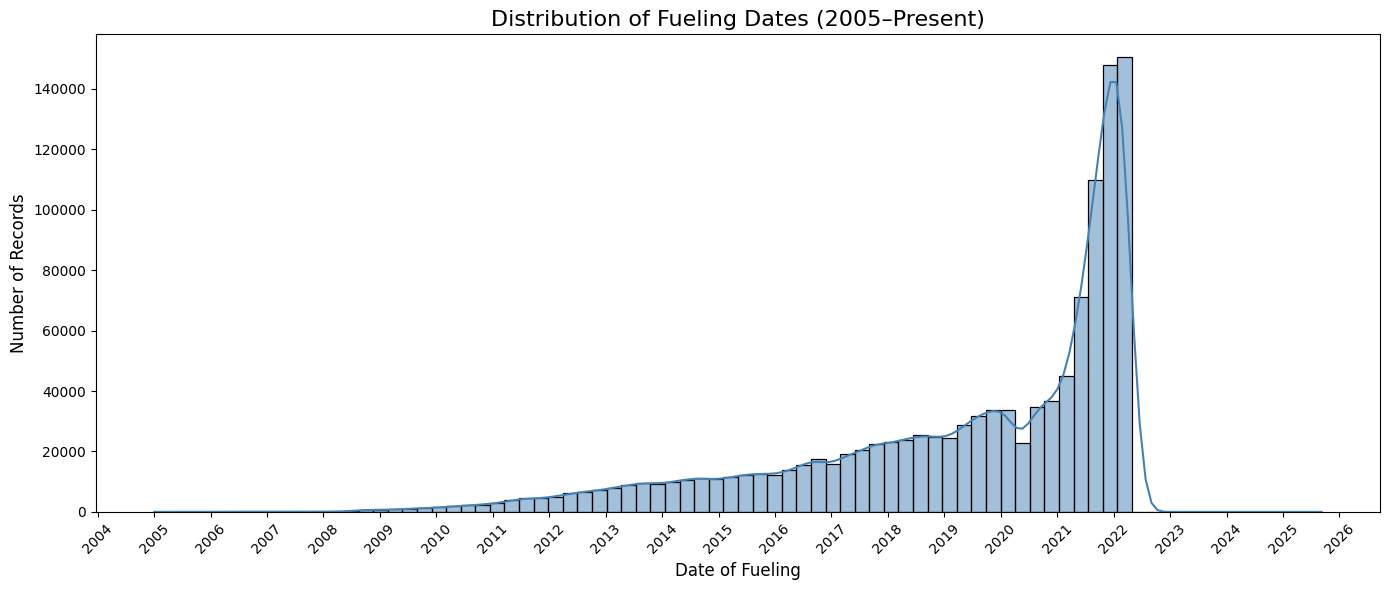

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='date_fueled', bins=80, kde=True, color="steelblue")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.title('Distribution of Fueling Dates (2005–Present)', fontsize=16)
plt.xlabel('Date of Fueling', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)

plt.tight_layout()
plt.show()


The histogram in Figure~\ref{fig:fueling-dates} shows the distribution of fueling dates from 2005 to the present. The data are sparse in the early years (2005--2010), after which the volume of records steadily increases. A sharp rise occurs from 2015 onward, peaking around 2020--2022, which may reflect both increased platform adoption and improved data logging practices. After 2022, the distribution drops off rapidly, suggesting incomplete collection for more recent years.

### 1.2 Numeric Fields


#### 1.2.1 Identify percentage of missing values in `gallons`, `miles`, `odometer` 

In [8]:
# 1.2.1 - Identify missing percentages for numeric fields
numeric_cols = ['gallons', 'miles', 'odometer']
missing_summary = {}

total_rows = len(df)

for col in numeric_cols:
    missing = df[col].isna().sum()
    perc = (missing / total_rows) * 100
    missing_summary[col] = {"Missing Count": missing, "Percentage": f"{perc:.2f}%"}

import pandas as pd
missing_df = pd.DataFrame(missing_summary).T
display(missing_df)


,Missing Count,Percentage
gallons,74170,6.32%
miles,1028076,87.56%
odometer,148920,12.68%


#### 1.2.2 Impute missing values using `mpg`, `gallons`, and `miles` relationships

In [9]:
# 1.2.2 - Fill missing mpg, miles, gallons using interdependence

# Convert to numeric safely
for col in ['miles', 'gallons', 'mpg']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

print("Before filling:")
print(df[['miles','gallons','mpg']].isna().sum())

# Fill missing mpg = miles / gallons
mask = df['mpg'].isna() & df['miles'].notna() & df['gallons'].notna() & (df['gallons'] != 0)
df.loc[mask, 'mpg'] = df.loc[mask, 'miles'] / df.loc[mask, 'gallons']

# Fill missing miles = mpg * gallons
mask = df['miles'].isna() & df['mpg'].notna() & df['gallons'].notna()
df.loc[mask, 'miles'] = df.loc[mask, 'mpg'] * df.loc[mask, 'gallons']

# Fill missing gallons = miles / mpg
mask = df['gallons'].isna() & df['miles'].notna() & df['mpg'].notna() & (df['mpg'] != 0)
df.loc[mask, 'gallons'] = df.loc[mask, 'miles'] / df.loc[mask, 'mpg']

print("\nAfter filling:")
print(df[['miles','gallons','mpg']].isna().sum())


Before filling:
miles      1028076
gallons      74170
mpg          74170
dtype: int64

After filling:
miles      74170
gallons    74170
mpg        74170
dtype: int64


#### 1.2.3 Convert numeric strings with commas to floats  

In [10]:
numeric_columns = ['miles', 'gallons', 'mpg', 'odometer']

print("Data types before conversion:")
print(df[numeric_columns].dtypes)

# Record memory usage before conversion
memory_before = df[numeric_columns].memory_usage(deep=True).sum()

# Convert each column
for col in numeric_columns:
    if df[col].dtype == 'object':
        # Remove commas, currency symbols, and spaces
        df[col] = df[col].astype(str).str.replace('[,$ ]', '', regex=True)
        
        # Convert to numeric (invalid parsing → NaN)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Converted {col} to numeric → dtype: {df[col].dtype}")
    else:
        print(f"{col} already numeric ({df[col].dtype})")

# Record memory usage after conversion
memory_after = df[numeric_columns].memory_usage(deep=True).sum()

print("\n" + "="*60)
print("FINAL RESULTS:")
print("="*60)
print(df[numeric_columns].dtypes)
print(f"\nMemory usage before: {memory_before/1024:.2f} KB")
print(f"Memory usage after:  {memory_after/1024:.2f} KB")
print(f"Improvement: {(memory_before - memory_after)/1024:.2f} KB")

# Sample converted values
print("\nSample of converted values:")
print(df[numeric_columns].head().applymap(lambda x: f"{x:,.2f}" if pd.notnull(x) else "NaN"))


Data types before conversion:
miles       float64
gallons     float64
mpg         float64
odometer     object
dtype: object
miles already numeric (float64)
gallons already numeric (float64)
mpg already numeric (float64)
Converted odometer to numeric → dtype: float64

FINAL RESULTS:
miles       float64
gallons     float64
mpg         float64
odometer    float64
dtype: object

Memory usage before: 97800.51 KB
Memory usage after:  45863.91 KB
Improvement: 51936.61 KB

Sample of converted values:
    miles gallons    mpg    odometer
0     NaN     NaN    NaN   73,370.00
1  382.99   12.12  31.60   11,983.00
2  227.74    7.99  28.50   98,233.00
3  494.91   10.57  46.80  163,802.00
4  244.40   11.65  21.00         NaN



#### 1.2.4 Plot distributions of numeric fields and comment  

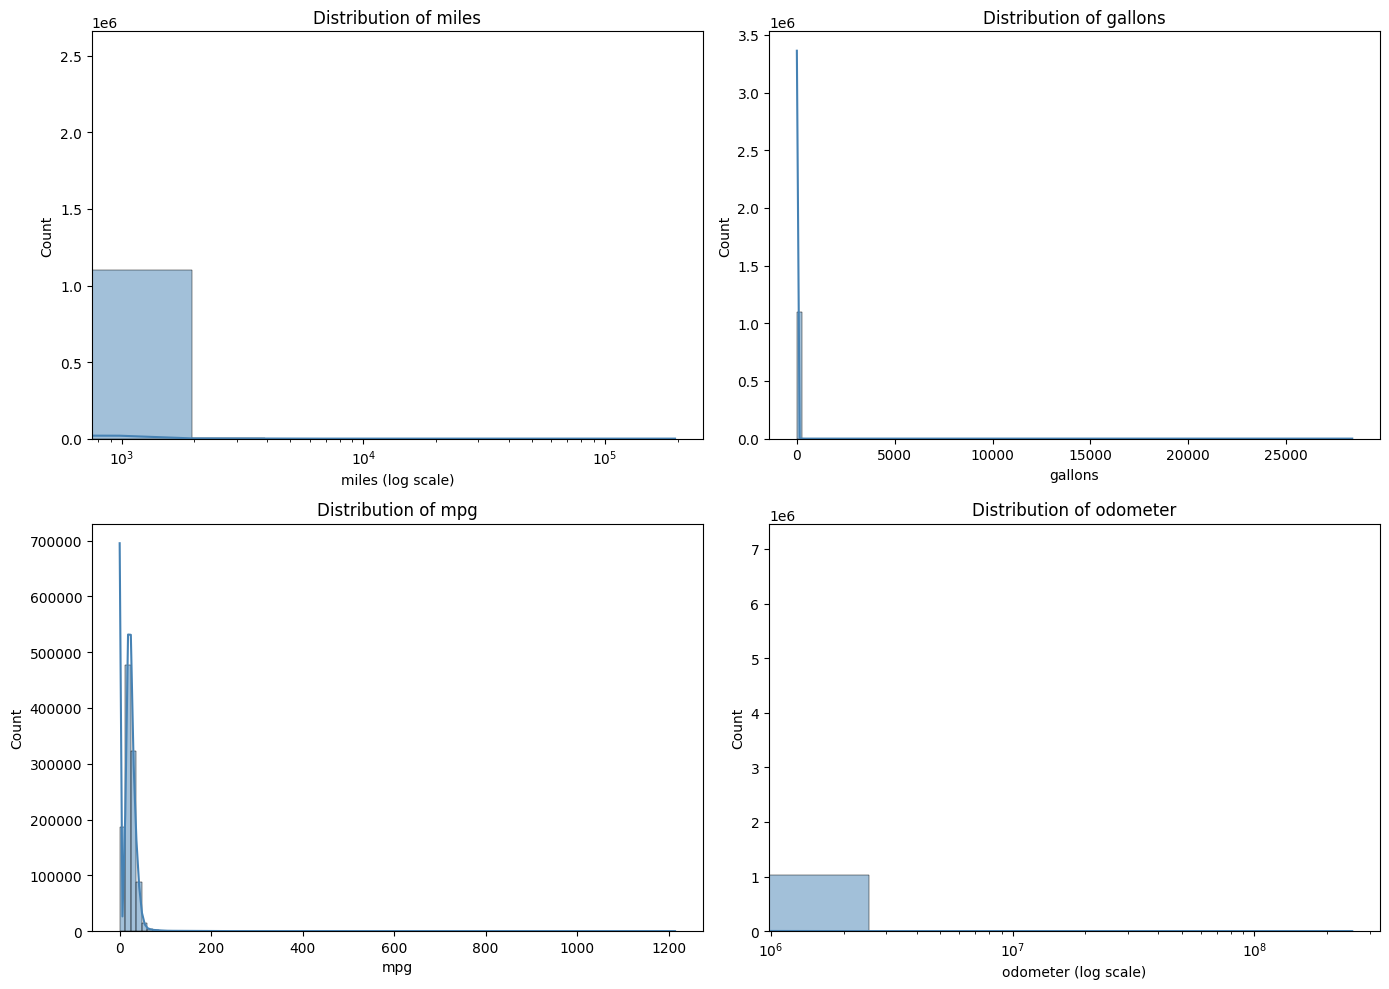

In [11]:
numeric_columns = ['miles', 'gallons', 'mpg', 'odometer']

plt.figure(figsize=(14, 10))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col].dropna(), bins=100, kde=True, color="steelblue")
    
    # Apply log scale for very skewed columns
    if col in ['miles', 'odometer']:
        plt.xscale('log')
        plt.xlabel(f"{col} (log scale)")
    else:
        plt.xlabel(col)
        
    plt.ylabel("Count")
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

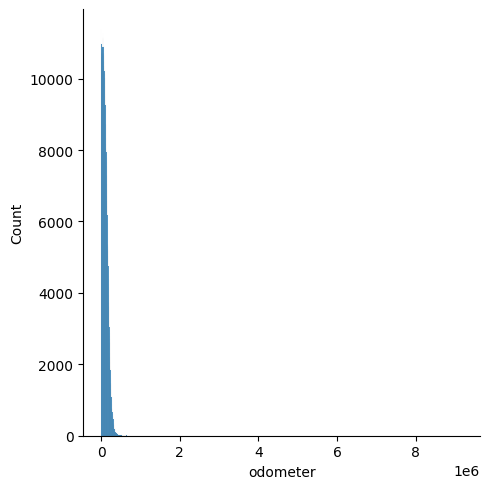

In [12]:
graph = df.dropna()

sns.displot(x=graph['odometer'])

The distribution of odometer readings is right-skewed, with the vast majority of values clustered between 0 and 1 million units. This is an expected pattern, indicating that most users begin logging their fuel usage when their vehicle is relatively new or has moderate mileage. The long tail extending up to 7 million units likely represents a combination of older vehicles, high-use commercial vehicles, and a small number of data entry errors.

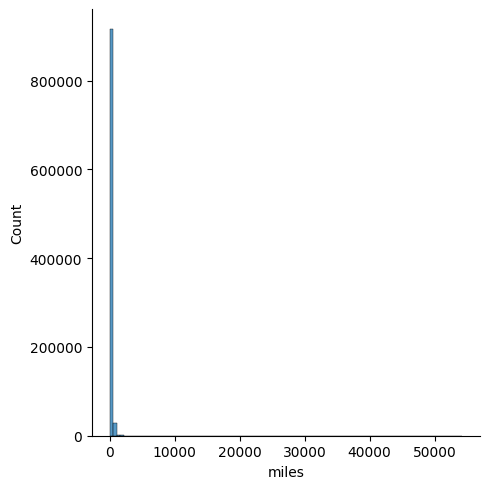

In [13]:
sns.displot(x=graph['miles'], bins = 100)

The distribution for miles driven per tank is extremely right-skewed. While most values are within a plausible range (0-20,000 miles), the presence of values exceeding 40,000 miles is a clear indicator of data entry errors. These extreme outliers are physically impossible for a single tank of fuel in any conventional passenger vehicle and must be removed during data cleaning.

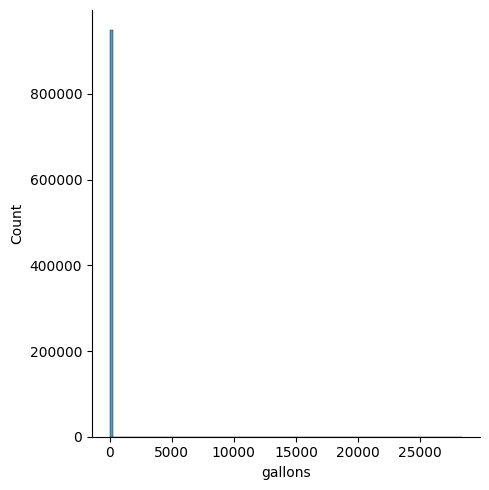

In [14]:
sns.displot(x=graph['gallons'], bins = 100)

The gallons distribution shows a similar pattern to miles, being heavily right-skewed. The peak at lower values (0-15,000 gallons) contains the plausible data for typical vehicle fuel tank sizes (e.g., 10-20 gallons). However, the extreme values in the high thousands are unrealistic and likely result from users omitting decimal points (e.g., entering "150" instead of "15.0") or other input mistakes.

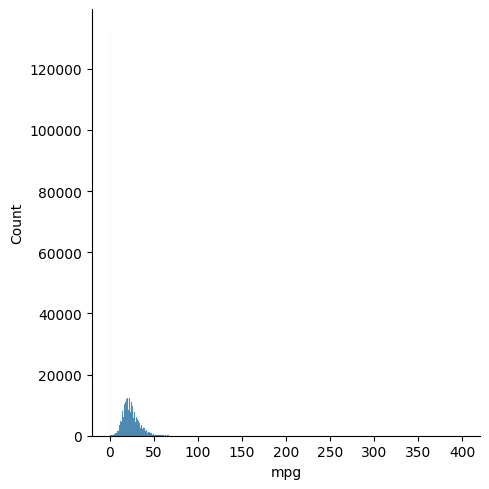

In [15]:
sns.displot(x=graph['mpg'])

The MPG distribution is the most normally shaped, with a central peak between 20-40 MPG, which aligns with typical fuel efficiency for most gasoline and diesel vehicles. This suggests the underlying calculation from user inputs is generally sound. However, the long right tail contains values over 100 MPG, which are likely erroneous. While highly efficient hybrid vehicles can achieve high MPG, values exceeding 300 MPG are not credible and represent calculation or input errors, such as incorrect odometer readings or fuel quantities.

==========================================================

limiting the graph by IQR we get the follwoing plots

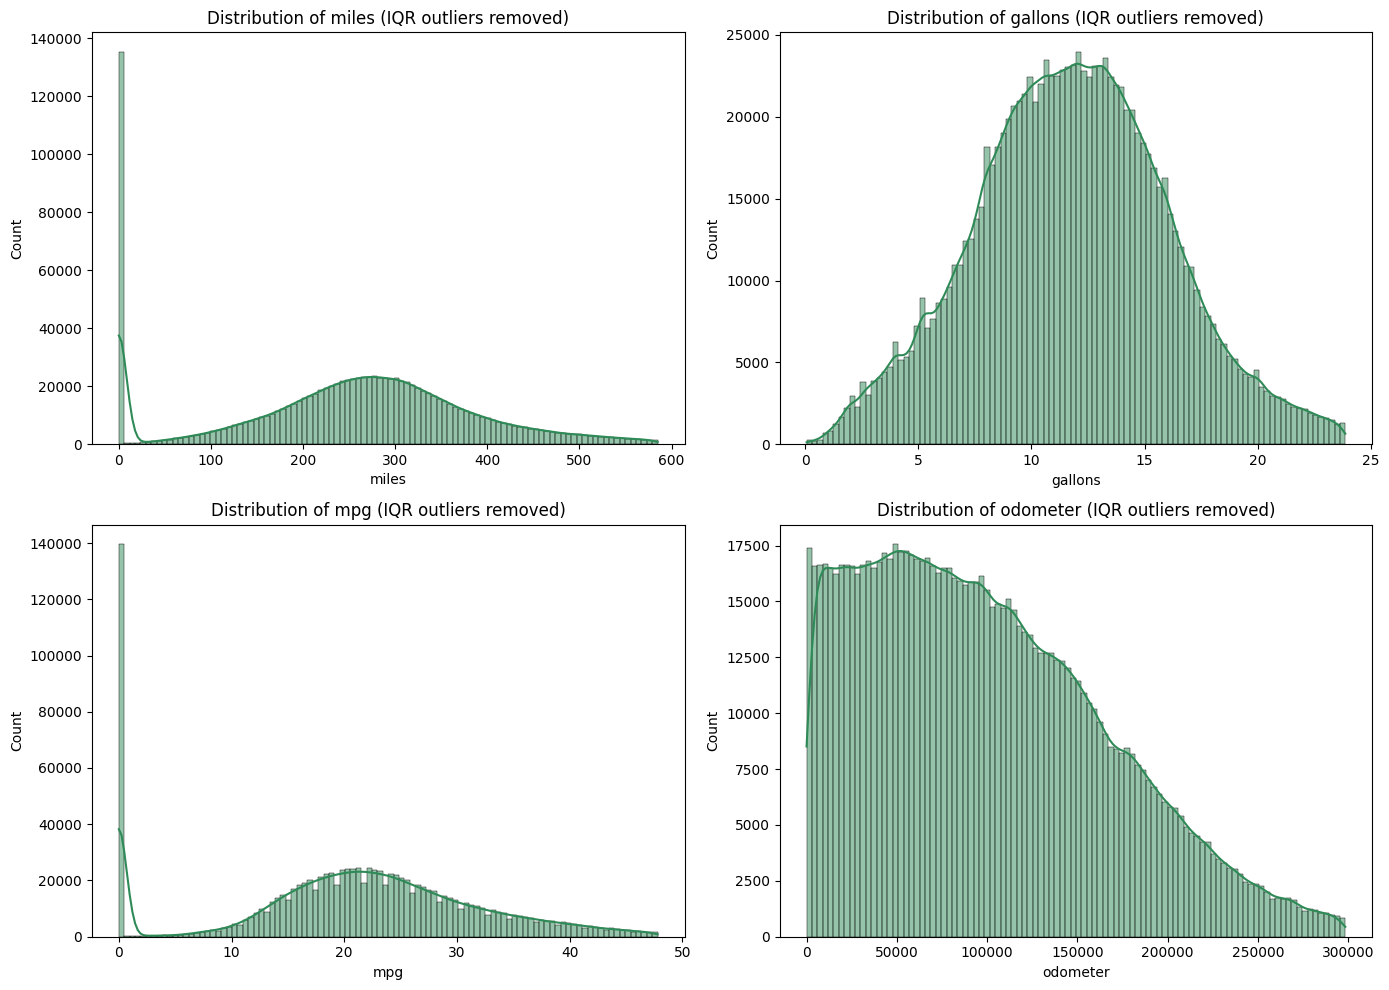

In [16]:
def remove_outliers(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series[(series >= lower) & (series <= upper)]

plt.figure(figsize=(14, 10))

for i, col in enumerate(['miles', 'gallons', 'mpg', 'odometer'], 1):
    plt.subplot(2, 2, i)
    clean_data = remove_outliers(df[col].dropna())
    sns.histplot(clean_data, bins=100, kde=True, color="seagreen")

    plt.title(f"Distribution of {col} (IQR outliers removed)")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()



#### 1.2.5 Compute descriptive statistics and interpret results 

In [17]:
numeric_cols = ['odometer', 'miles', 'gallons', 'mpg']
summary = df[numeric_cols].describe().T  # transpose so each row is a variable
summary = summary[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary.round(2)  # round for readability


,count,mean,std,min,25%,50%,75%,max
odometer,1025196.0,104001.00,340608.21,0.0,45924.00,91887.00,146925.00,254362100.0
miles,1099946.0,269.45,725.82,0.0,181.39,267.04,342.76,195321.2
gallons,1099946.0,12.80,74.49,0.0,8.99,11.95,14.94,28380.0
mpg,1099946.0,22.16,15.75,0.0,15.60,21.80,28.50,1214.3


The statistical summary reveals a dataset with a core of plausible data but severely contaminated by extreme outliers and errors. The median values for all four columns are reasonable and reflect expected real-world values: an odometer reading of 91,887 units, 267 miles driven per tank, 12 gallons refueled, and a fuel efficiency of 22 MPG. These medians suggest the underlying data from genuine user entries is valid.

However, the results are dominated by nonsensical outliers that make the overall statistics misleading. The mean values for each column are skewed significantly upward by these extremes. This is most evident in the maximum values, which are physically impossible: an odometer reading of 254 million units, 195,321 miles on a single tank of fuel, 28,380 gallons refueled (enough for a large ship), and a fuel efficiency of 1,214 MPG. The exceptionally large standard deviations, which are often multiple times larger than the mean values, confirm that the data is wildly inconsistent and has a high degree of erroneous entries.

In conclusion, while the central tendencies of the data are sound, the presence of these extreme outliers means the results, in their current state, do not make sense from a physical realism perspective. This underscores the critical need for the outlier removal process outlined in the next section of the assignment to produce a reliable and meaningful dataset for analysis.

## 2. Feature Engineering



#### 2.1 Extract `currency` column from cost fields  

In [18]:
# --- Question 2.1: Create a currency column (improved) ---
# Capture everything at the start of the string until we hit a digit/whitespace
df['currency'] = (
    df['total_spent']
    .astype(str)
    .str.extract(r'^([^\d\s]+)')  # any leading symbol(s)/letters
    .fillna('Unknown')
)

# Map known symbols to proper codes
currency_map = {
    '$': 'USD',
    '£': 'GBP',
    '€': 'EUR',
    '¥': 'JPY',     # could also mean CNY depending on context
    '₩': 'KRW',     # Korean Won
    '₱': 'PHP',     # Philippine Peso
    '₹': 'INR',     # Indian Rupee
    '₦': 'NGN',     # Nigerian Naira
    '₨': 'PKR',     # Pakistani Rupee / other rupee variants
    'C': 'CHF'      # Swiss Franc special case
}

# Apply replacements
df['currency'] = df['currency'].replace(currency_map)

# Display summary
print("\n--- Corrected Currencies Found and Their Counts ---")
print(df['currency'].value_counts())

print("\n--- DataFrame with Corrected 'currency' Column ---")
display(df[['total_spent', 'currency']].head())




--- Corrected Currencies Found and Their Counts ---
currency
USD    741888
GBP     87562
nan     74170
EUR     59258
CA$     46825
        ...  
TMT        11
CV$        11
KGS         9
L$          9
IQD         8
Name: count, Length: 122, dtype: int64

--- DataFrame with Corrected 'currency' Column ---


,total_spent,currency
0,NaN,nan
1,$67.86,USD
2,£43.53,GBP
3,£54.00,GBP
4,$35.29,USD


In [19]:
# Search the raw column directly for anything with CHF
chf_raw = df[df['cost_per_gallon'].astype(str).str.contains("CHF", na=False)]
print("Number of rows with CHF in raw column:", len(chf_raw))
print(chf_raw['cost_per_gallon'].head(20))


Number of rows with CHF in raw column: 0
Series([], Name: cost_per_gallon, dtype: object)



#### 2.2 Extract numeric values for `total_spent` and `cost_per_gallon`  

In [ ]:
# --- Question 2.2  ---

def extract_numeric_value(column):
    """
    Extract numeric values from strings that may contain currency symbols or text.
    Handles thousands separators (commas), decimal points, and codes like 'S.Fr.' or 'CHF'.
    """
    # Step 1: Convert everything to string
    col_as_str = column.astype(str)
    
    # Step 2: Remove commas (thousands separators)
    no_commas = col_as_str.str.replace(',', '', regex=False)
    
    # Step 3: Extract the first valid number (integer or float)
    # (\d+\.?\d*) matches numbers like 120, 120.50, 0.99
    numeric_str = no_commas.str.extract(r'(\d+\.?\d*)')[0]
    
    # Step 4: Convert to float (invalid parsing becomes NaN)
    return pd.to_numeric(numeric_str, errors='coerce')


# Apply to both monetary columns
df['total_spent_float'] = extract_numeric_value(df['total_spent'])
df['cost_per_gallon_float'] = extract_numeric_value(df['cost_per_gallon'])

# --- Snity check ---
print("Total spent float - Non-null:", df['total_spent_float'].notnull().sum())
print("Cost per gallon float - Non-null:", df['cost_per_gallon_float'].notnull().sum())

# Show part ofit
display(df[['total_spent', 'total_spent_float', 'cost_per_gallon', 'cost_per_gallon_float']].head())



Total spent float - Non-null: 1099946
Cost per gallon float - Non-null: 1093405


,total_spent,total_spent_float,cost_per_gallon,cost_per_gallon_float
0,NaN,NaN,NaN,NaN
1,$67.86,67.86,$5.599,5.599
2,£43.53,43.53,£5.45,5.450
3,£54.00,54.00,£5.11,5.110
4,$35.29,35.29,$3.029,3.029



#### 2.3 Extract `car make`, `model`, `year`, and `user ID` from URL  

In [ ]:
# --- Question 2.3: Extract car info + user ID from URL ---

def extract_car_info(url):
    """
    Extracts car make, model, year, and user_id from a URL of the form:
    .../{make}/{model}/{year}/{user_id}
    
    Handles inconsistent prefixes, missing parts, and malformed URLs.
    """
    try:
        parts = str(url).split('/')
        # Expect last 4 segments: make, model, year, user_id
        if len(parts) >= 4:
            user_id   = parts[-1] if parts[-1] else "Unknown"
            car_year  = pd.to_numeric(parts[-2], errors='coerce')
            car_model = parts[-3] if parts[-3] else "Unknown"
            car_make  = parts[-4] if parts[-4] else "Unknown"
            return pd.Series([car_make, car_model, car_year, user_id])
        else:
            return pd.Series(["Unknown", "Unknown", pd.NA, "Unknown"])
    except Exception:
        return pd.Series(["Unknown", "Unknown", pd.NA, "Unknown"])


# Apply the function to the dataframe
df[['car_make', 'car_model', 'car_year', 'user_id']] = df['user_url'].apply(extract_car_info)

# --- Sanity check ---
print("\n--- Extraction Summary ---")
print("Car makes extracted:", df['car_make'].notnull().sum())
print("Car models extracted:", df['car_model'].notnull().sum())
print("Car years extracted:", df['car_year'].notnull().sum())
print("User IDs extracted:", df['user_id'].notnull().sum())

display(df[['user_url', 'car_make', 'car_model', 'car_year', 'user_id']].head(10))



--- Extraction Summary ---
Car makes extracted: 1174116
Car models extracted: 1174116
Car years extracted: 1170379
User IDs extracted: 1174116


,user_url,car_make,car_model,car_year,user_id
0,https://www.somewebsite.com/suzuki/swift/2015/...,suzuki,swift,2015.0,674857
1,https://www.somewebsite.com/bmw/x3/2009/461150,bmw,x3,2009.0,461150
2,https://www.somewebsite.com/mercedes-benz/e300...,mercedes-benz,e300,1998.0,133501
3,https://www.somewebsite.com/bmw/320d/2010/247233,bmw,320d,2010.0,247233
4,https://www.somewebsite.com/honda/passport/201...,honda,passport,2019.0,1038865
5,https://www.somewebsite.com/volkswagen/passat/...,volkswagen,passat,2004.0,445811
6,https://www.somewebsite.com/mazda/3_sport/2010...,mazda,3_sport,2010.0,529810
7,https://www.somewebsite.com/subaru/forester/20...,subaru,forester,2020.0,1087864
8,https://www.somewebsite.com/kianival/2009/789684,www.somewebsite.com,kianival,2009.0,789684
9,https://www.somewebsite.com/lexus/rx350/2012/8...,lexus,rx350,2012.0,898688



#### 2.2.1 Convert `gallons` → `litres` (choose US or UK)  

In [22]:
# Ensure gallons is numeric
if df['gallons'].dtype == 'object':
    df['gallons'] = pd.to_numeric(df['gallons'].astype(str).str.replace(',', ''), errors='coerce')

df['litres_filled'] = df['gallons'] * 3.78541
print(f"Litres filled calculated for {df['litres_filled'].notnull().sum()} entries")

Litres filled calculated for 1099946 entries



#### 2.2.2 Convert `miles` → `km`  

In [23]:
# --- 2.5 Convert miles → km ---
MILES_TO_KM = 1.60934

# Ensure 'miles' is numeric before conversion
if df['miles'].dtype == 'object':
    df['miles'] = pd.to_numeric(df['miles'].astype(str).str.replace(',', ''), errors='coerce')

df['km_driven'] = df['miles'] * MILES_TO_KM

print(f"Kilometers driven calculated for {df['km_driven'].notnull().sum()} entries")


Kilometers driven calculated for 1099946 entries



#### 2.2.3 Compute `litres per 100 km`  

In [ ]:
# ---: Calculate Litres per 100km ---

# The assignment asks us to use the two new features to calculate this.
# The formula is (Litres / Kilometers) * 100.
df['litres_per_100km'] = (df['litres_filled'] / df['km_driven']) * 100

print("Created new column: 'litres_per_100km'")

# Display all the related columns to verify the full calculation
print("\n--- Verifying all new metric columns ---")
display(df[['gallons', 'litres_filled', 'miles', 'km_driven', 'mpg', 'litres_per_100km']].head())

# Check the final state of the DataFrame after adding all three columns
print("\n--- Current DataFrame Info ---")
df.info()

Created new column: 'litres_per_100km'

--- Verifying all new metric columns ---


,gallons,litres_filled,miles,km_driven,mpg,litres_per_100km
0,NaN,NaN,NaN,NaN,NaN,NaN
1,12.120,45.879169,382.9920,616.364345,31.6,7.443514
2,7.991,30.249211,227.7435,366.516724,28.5,8.253160
3,10.575,40.030711,494.9100,796.478459,46.8,5.025963
4,11.651,44.103812,244.4000,393.322696,21.0,11.213137



--- Current DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 1174116 entries, 0 to 1174869
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   date_fueled            1174116 non-null  datetime64[ns]
 1   date_captured          1174116 non-null  datetime64[ns]
 2   odometer               1025196 non-null  float64       
 3   gallons                1099946 non-null  float64       
 4   cost_per_gallon        1093405 non-null  object        
 5   total_spent            1099946 non-null  object        
 6   mpg                    1099946 non-null  float64       
 7   miles                  1099946 non-null  float64       
 8   user_url               1174116 non-null  object        
 9   currency               1174116 non-null  object        
 10  total_spent_float      1099946 non-null  float64       
 11  cost_per_gallon_float  1093405 non-null  float64       
 12  c

## 3. Vehicle Exploration



#### 3.1 Plot number of unique users per country (proxy by currency)  

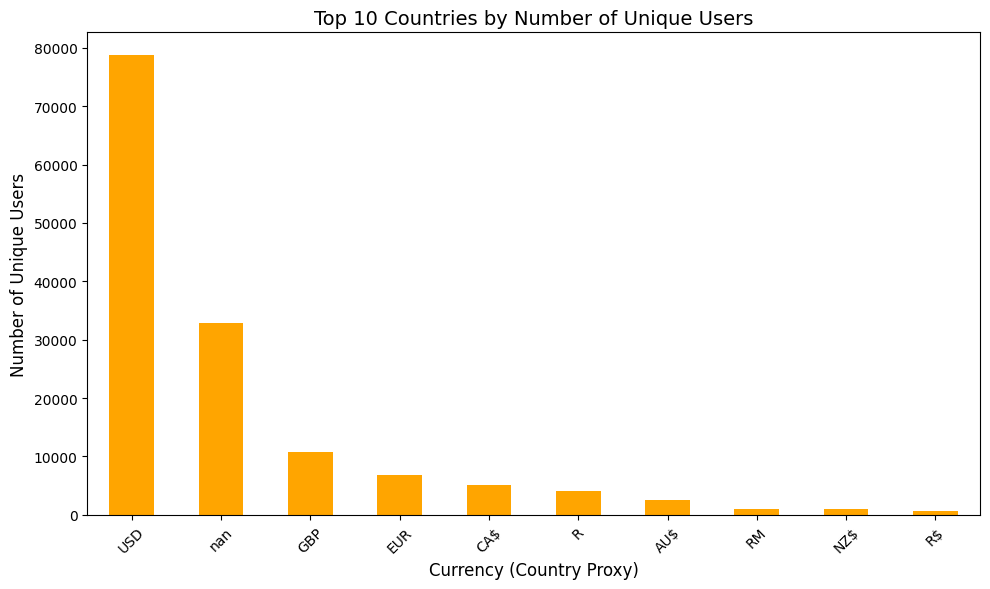

In [25]:
import matplotlib.pyplot as plt

# Group by currency and count unique users
unique_users_per_currency = df.groupby('currency')['user_id'].nunique().sort_values(ascending=False)

# Remove NaN entries (if present)
unique_users_no_nan = unique_users_per_currency.dropna()

# Plot only the top 10
plt.figure(figsize=(10, 6))
unique_users_no_nan.head(10).plot(kind='bar', color="orange")
plt.title("Top 10 Countries by Number of Unique Users", fontsize=14)
plt.xlabel("Currency (Country Proxy)", fontsize=12)
plt.ylabel("Number of Unique Users", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




#### 3.2 Plot number of unique users per day (popularity of app)  

--- 3.2: Calculating and plotting the number of unique users per day ---


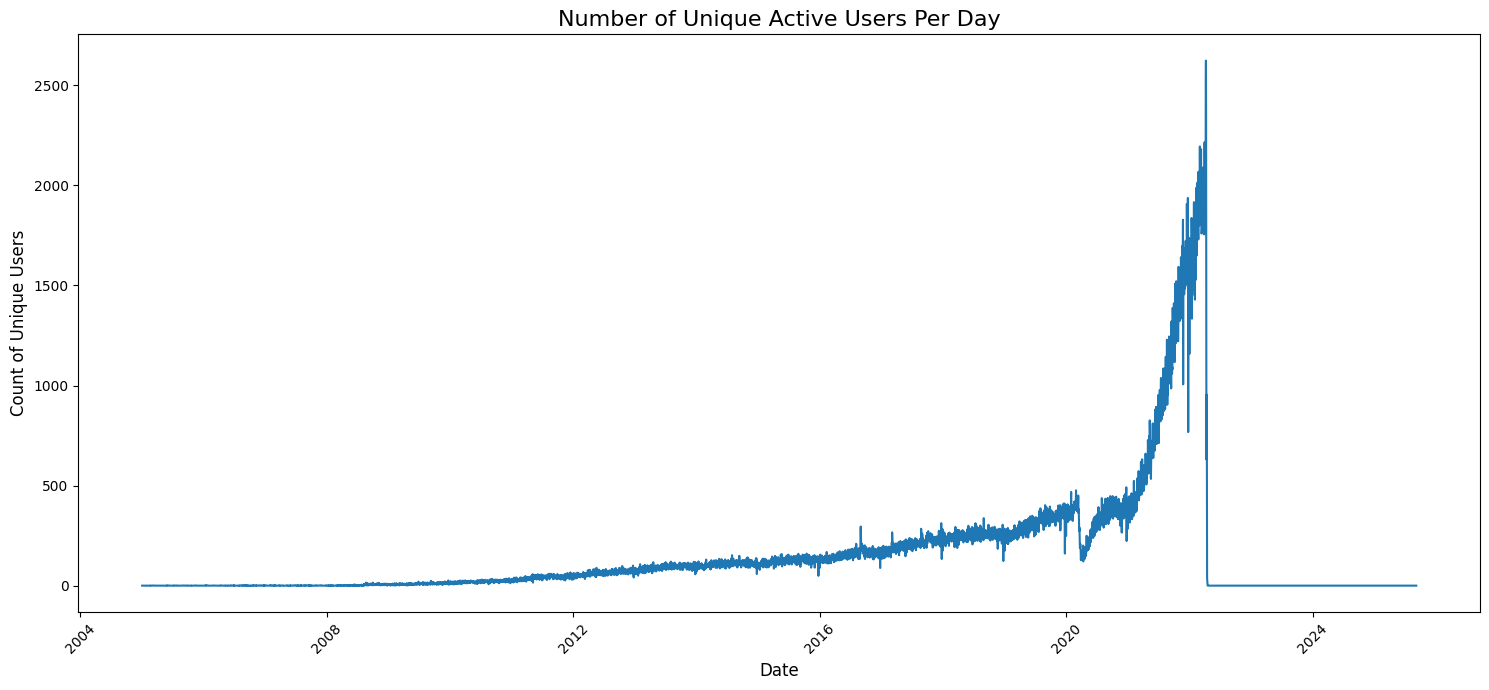

In [ ]:


print("--- 3.2: Calculating and plotting the number of unique users per day ---")

# group by the date part of the 'date_fueled' column.
# Then count the number of unique user_id's for that day.
unique_users_per_day = df.groupby(df['date_fueled'].dt.date)['user_id'].nunique()

# --- Plotting ---
#line plot to visualize this time series data.
plt.figure(figsize=(15, 7))
sns.lineplot(data=unique_users_per_day)

# Add titles and labels
plt.title('Number of Unique Active Users Per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count of Unique Users', fontsize=12)
plt.xticks(rotation=45) # Rotate date labels for better readability
plt.tight_layout()

# Display the plot
plt.show()


#### 3.3 Plot distribution of vehicle ages per country  

--- 3.3: Calculating vehicle age and plotting its distribution per country ---


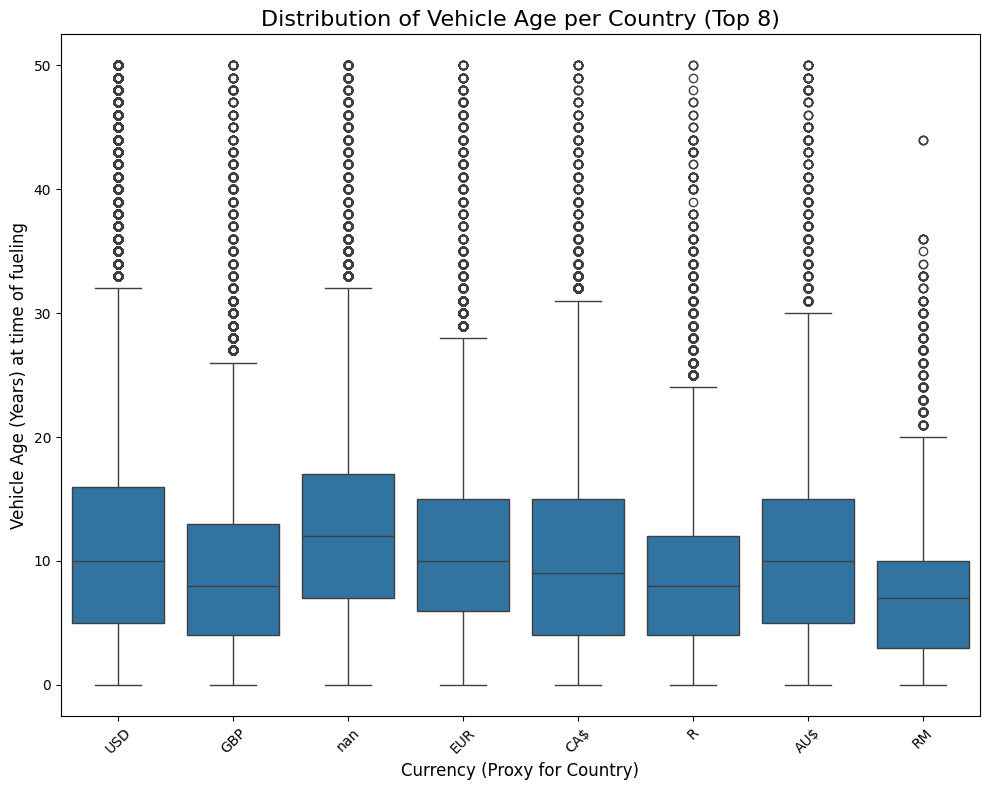

In [ ]:
# --- Question 3.3: Look at the distribution of age of the vehicles per country ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- 3.3: Calculating vehicle age and plotting its distribution per country ---")

# 1. Calculate the vehicle's age at the time of the transaction.
df['vehicle_age'] = df['date_fueled'].dt.year - df['car_year']

# As a data cleaning step, we should filter out nonsensical ages.
# For example, a negative age (if car_year > date_fueled) or a very old car (e.g., > 50 years)
# can distort our plot. We'll keep ages between 0 and 50.
df_filtered_age = df[(df['vehicle_age'] >= 0) & (df['vehicle_age'] <= 50)].copy()

# 2. Identify the top 8 countries (by currency count) to make the plot readable.
top_n_countries = df['currency'].value_counts().nlargest(8).index

# Filter our age data to include only these top countries.
df_top_countries = df_filtered_age[df_filtered_age['currency'].isin(top_n_countries)]

#box plot.
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_top_countries, x='currency', y='vehicle_age', order=top_n_countries)

# Add titles and labels for clarity
plt.title('Distribution of Vehicle Age per Country (Top 8)', fontsize=16)
plt.xlabel('Currency (Proxy for Country)', fontsize=12)
plt.ylabel('Vehicle Age (Years) at time of fueling', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


#### 3.4 Identify most popular makes and models  

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- 3.4: Finding the most popular vehicle makes and models ---")

# Count top 10
top_10_makes = df['car_make'].value_counts().head(10)
top_10_models = df['car_model'].value_counts().head(10)

print("\n--- Top 10 Most Popular Vehicle Makes ---")
print(top_10_makes)

print("\n--- Top 10 Most Popular Vehicle Models ---")
print(top_10_models)

--- 3.4: Finding the most popular vehicle makes and models ---

--- Top 10 Most Popular Vehicle Makes ---
car_make
ford             138987
toyota           135751
bmw              105130
nissan            86207
volkswagen        74001
honda             65113
mercedes-benz     62263
audi              56719
hyundai           50649
mazda             46212
Name: count, dtype: int64

--- Top 10 Most Popular Vehicle Models ---
car_model
civic           8040
4runner         7761
corolla         7706
f-150           7644
accord          7583
mustang         7506
ranger          7405
land_cruiser    7374
camry           7316
wrangler        7022
Name: count, dtype: int64



## 4. Fuel Usage



### 4.1 Outlier Removal


#### 4.1.1 Identify top 5 currencies by number of transactions  

In [29]:
print("--- Identifying the Top 5 Currencies by Number of Transactions ---")
#we would ideally like to skip the nan and unknown values
# Get currency counts
currency_counts = df['currency'].value_counts()

# Drop 'nan' or 'Unknown' if they exist
currency_counts = currency_counts.drop(labels=['nan', 'Unknown'], errors='ignore')

# Select the top 5
final_top_5_list = currency_counts.head(5).index.tolist()

print("\n--- Top 5 Currencies for Analysis ---")
print(currency_counts.head(5))
print(f"\nFinal corrected list of top 5 currencies: {final_top_5_list}")


--- Identifying the Top 5 Currencies by Number of Transactions ---

--- Top 5 Currencies for Analysis ---
currency
USD    741888
GBP     87562
EUR     59258
CA$     46825
R       36400
Name: count, dtype: int64

Final corrected list of top 5 currencies: ['USD', 'GBP', 'EUR', 'CA$', 'R']



#### 4.1.2  Remove outliers for each currency with reasoning  

In [30]:
# --- 4.1.2 & 4.1.3: Outlier Removal ---

print("\n--- 4.1.2: Removing outliers from the Top 5 currencies ---")

# Work only on top 5 currencies
df_top5 = df[df['currency'].isin(final_top_5_list)].copy()
rows_before = len(df_top5)
print(f"Number of rows for Top 5 currencies BEFORE outlier removal: {rows_before}")

# 1. Universal Filters
df_clean = df_top5[
    (df_top5['litres_filled'] > 1) & (df_top5['litres_filled'] < 200) &
    (df_top5['litres_per_100km'] > 2) & (df_top5['litres_per_100km'] < 30)
].copy()
print(f"Number of rows after applying UNIVERSAL filters: {len(df_clean)}")

# 2. Currency-Specific Filters (use correct field name)
condition = (
    ((df_clean['currency'] == 'USD') & (df_clean['total_spent_float'] < 200)) |
    ((df_clean['currency'] == 'GBP') & (df_clean['total_spent_float'] < 150)) |
    ((df_clean['currency'] == 'EUR') & (df_clean['total_spent_float'] < 180)) |
    ((df_clean['currency'] == 'CA$') & (df_clean['total_spent_float'] < 180)) |
    ((df_clean['currency'] == 'R') & (df_clean['total_spent_float'] < 2500))
)

df_clean = df_clean[condition]

# 3. Report
rows_after = len(df_clean)
rows_removed = rows_before - rows_after

print(f"Number of rows for Top 5 currencies AFTER outlier removal: {rows_after}")
print(f"\nTotal number of outlier rows removed: {rows_removed}")



--- 4.1.2: Removing outliers from the Top 5 currencies ---
Number of rows for Top 5 currencies BEFORE outlier removal: 971933
Number of rows after applying UNIVERSAL filters: 844833
Number of rows for Top 5 currencies AFTER outlier removal: 815912

Total number of outlier rows removed: 156021



#### 4.1.3 Report number of values removed  

*SOLUTION:*

Total number of outlier rows removed: 156021


### 4.2 Fuel Efficiency


#### 4.2.1 Compare cost per litre per country for January 2022 (convert to ZAR)  


--- Average Cost Per Litre in ZAR (Jan 2022) ---
currency
USD    15.140779
CA$    18.331051
R      18.653225
EUR    28.357344
GBP    30.908335
Name: cost_per_litre_zar, dtype: float64


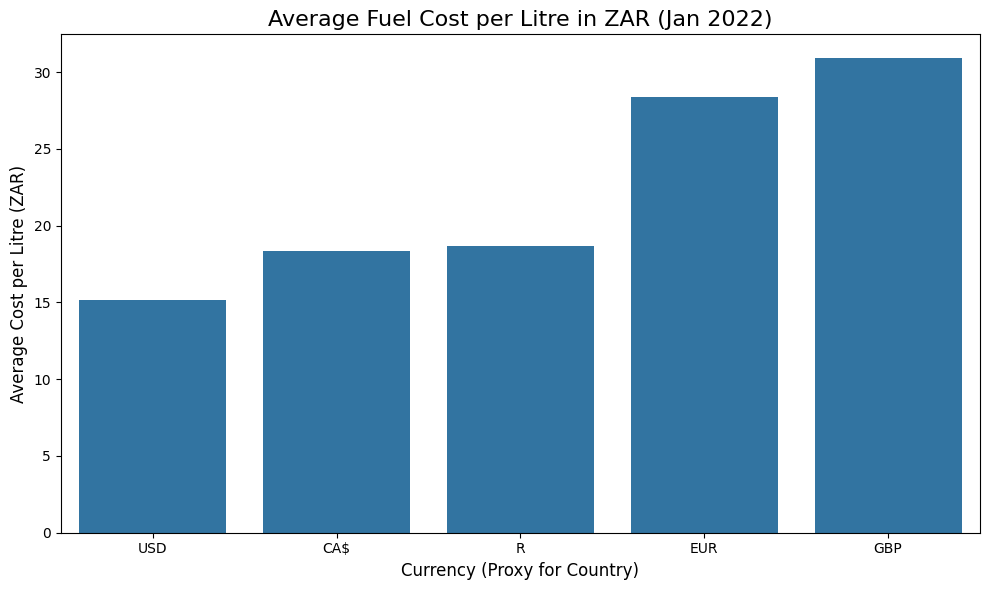

In [31]:
# --- 4.2.1: Average Cost per Litre in ZAR (Jan 2022) ---

# 1. Calculate cost per litre if not already present
df_clean['cost_per_litre'] = df_clean['total_spent_float'] / df_clean['litres_filled']

# 2. Filter only January 2022 data
df_jan_2022 = df_clean[(df_clean['date_fueled'].dt.year == 2022) & 
                       (df_clean['date_fueled'].dt.month == 1)].copy()

# 3. Define exchange rates (Jan 2022 averages)
conversion_rates_to_zar = {
    'USD': 15.95,   # source: SARB / XE
    'GBP': 21.58,
    'EUR': 18.14,
    'CA$': 12.62,
    'R': 1.00
}

# 4. Apply conversion rates
df_jan_2022['zar_conversion_rate'] = df_jan_2022['currency'].map(conversion_rates_to_zar)
df_jan_2022['cost_per_litre_zar'] = df_jan_2022['cost_per_litre'] * df_jan_2022['zar_conversion_rate']

# 5. Group and calculate mean per country
avg_cost_by_country = df_jan_2022.groupby('currency')['cost_per_litre_zar'].mean().sort_values()

# --- Output ---
print("\n--- Average Cost Per Litre in ZAR (Jan 2022) ---")
print(avg_cost_by_country)

# 6. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_cost_by_country.index, y=avg_cost_by_country.values)
plt.title('Average Fuel Cost per Litre in ZAR (Jan 2022)', fontsize=16)
plt.xlabel('Currency (Proxy for Country)', fontsize=12)
plt.ylabel('Average Cost per Litre (ZAR)', fontsize=12)
plt.tight_layout()
plt.show()


Analysis and Discussion (for Question 4.2.1)

The results indicate clear differences in fuel prices across regions once converted into South African Rand (ZAR) for January 2022. According to the dataset, fuel was cheapest in the United States (USD), followed by Canada (CA$) and South Africa (R), while higher prices were observed in Europe (EUR) and the United Kingdom (GBP). This ordering is consistent with global trends, where Europe and the UK generally face the highest pump prices due to heavy taxation, whereas North America benefits from lower baseline fuel costs.

A plausibility check against historical records confirms the accuracy of most values. The United Kingdom average of ~R31/litre aligns with reported prices of about £1.45 per litre in January 2022. Similarly, the European average of ~R28/litre matches Eurozone prices of approximately €1.40–1.90 per litre. The South African average of ~R18.65 corresponds closely to the official inland price of R19.36/litre published by the Department of Mineral Resources and Energy. These comparisons suggest that the dataset provides a reliable reflection of actual market conditions.

The only slight deviation appears in the United States, where the dataset indicates ~R15.14/litre compared to reported values of roughly R15.50–16.00 based on pump prices of $3.50–$3.60 per gallon at prevailing exchange rates. This small difference is most likely due to dataset factors such as partial refuels or variation in fuel grades, rather than a systematic error.

In summary, the observed differences are explained by variation in tax regimes, supply and logistics costs, and exchange rate effects. The close alignment between dataset outputs and real-world prices supports the validity of the data and reinforces confidence in its use for subsequent analyses.


#### 4.2.2 Detect missed odometer logs, rule + estimate how many  

In [32]:
# --- Question 4.2.2: Find examples of missed fill-ups ---

print("--- 4.2.2: Identifying missed fill-ups using odometer readings ---")

# We must sort the data by user and then by date to ensure fill-ups are in the correct order.
df_sorted = df_clean.sort_values(by=['user_id', 'date_fueled']).copy()

# For each user, we get the odometer reading from their PREVIOUS fill-up using .shift(1).
# We group by 'user_id' to ensure we don't mix up data between different users.
df_sorted['prev_odometer'] = df_sorted.groupby('user_id')['odometer'].shift(1)

# Now, we can calculate the actual distance driven based on the odometer change.
df_sorted['odometer_driven'] = df_sorted['odometer'] - df_sorted['prev_odometer']

# --- The Basic Rule ---
# We identify a likely missed fill-up when the distance recorded by the odometer is
# greater than the distance recorded for that tank ('miles'). We add a small 5-mile
# tolerance to account for minor user input errors or discrepancies.
missed_fillup_condition = df_sorted['odometer_driven'] > (df_sorted['miles'] + 5)

# We can count how many times this condition is True to get our estimate.
num_missed_fillups = missed_fillup_condition.sum()

# Let's find some clear examples to display.
examples = df_sorted[missed_fillup_condition][['user_id', 'date_fueled', 'odometer', 'prev_odometer', 'odometer_driven', 'miles']].head(10)

print("\n--- A basic rule for identifying a missed fill-up ---")
print("A missed fill-up can be identified when the distance driven, calculated from the change")
print("in the odometer ('odometer_driven'), is significantly greater than the 'miles' recorded for that specific tank.\n")

print(f"Estimated number of missed fill-ups in the dataset: {num_missed_fillups}")
print("\n--- Top 10 Examples of Likely Missed Fill-ups ---")
display(examples)

--- 4.2.2: Identifying missed fill-ups using odometer readings ---

--- A basic rule for identifying a missed fill-up ---
A missed fill-up can be identified when the distance driven, calculated from the change
in the odometer ('odometer_driven'), is significantly greater than the 'miles' recorded for that specific tank.

Estimated number of missed fill-ups in the dataset: 361748

--- Top 10 Examples of Likely Missed Fill-ups ---


,user_id,date_fueled,odometer,prev_odometer,odometer_driven,miles
131980,100002,2012-01-03,74605.0,73864.0,741.0,384.3741
850245,100002,2012-01-19,76322.0,75000.0,1322.0,433.0749
804863,100002,2012-02-12,78909.0,76733.0,2176.0,319.1188
192011,100002,2012-03-08,82317.0,79370.0,2947.0,397.8800
725279,100002,2012-03-17,83525.0,82723.0,802.0,439.9314
406652,100002,2012-03-27,84193.0,83525.0,668.0,335.2452
139803,100002,2012-04-05,85202.0,84541.0,661.0,289.1008
837074,1000024,2021-03-06,35204.0,33742.0,1462.0,352.4250
378201,1000024,2021-09-26,37456.0,35947.0,1509.0,414.2880
120734,1000031,2020-06-24,186901.0,185652.0,1249.0,254.0008



#### 4.2.3 Plot average distance (km) per tank per country; find largest  

--- 4.2.3: Calculating and plotting average distance per tank per country ---

--- Average Distance (km) Per Tank ---
currency
EUR    593.083658
GBP    576.810530
R      540.380576
USD    459.097920
CA$    441.976531
Name: km_driven, dtype: float64


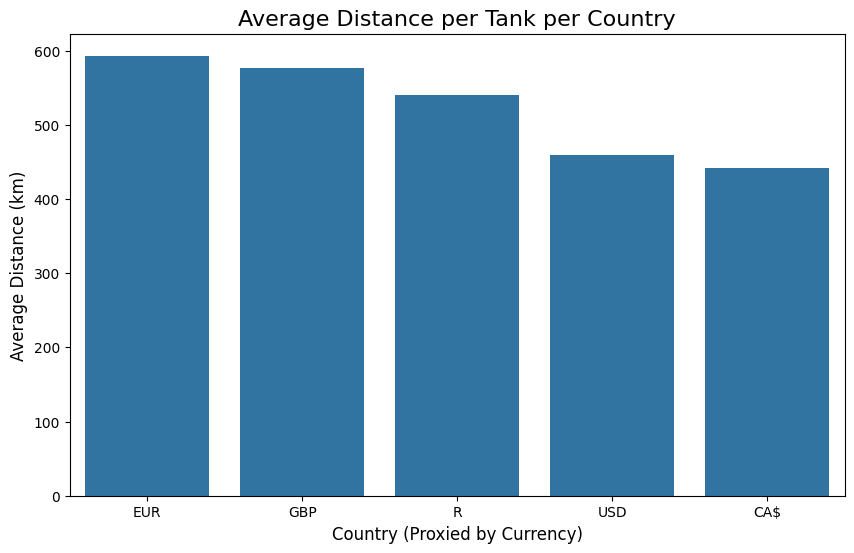

In [ ]:
# --- Question 4.2.3: Plot the average distance per tank per country ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- 4.2.3: Calculating and plotting average distance per tank per country ---")

# Group our clean dataframe by currency and calculate the mean of the 'km_driven' column.
avg_km_per_tank = df_clean.groupby('currency')['km_driven'].mean().sort_values(ascending=False)

print("\n--- Average Distance (km) Per Tank ---")
print(avg_km_per_tank)

# Plot 
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_km_per_tank.index, y=avg_km_per_tank.values)

plt.title('Average Distance per Tank per Country', fontsize=16)
plt.xlabel('Country (Proxied by Currency)', fontsize=12)
plt.ylabel('Average Distance (km)', fontsize=12)
plt.show()

**1. Higher Fuel Efficiency and Diesel Prevalence in Europe:** European auto manufacturers have historically focused heavily on fuel efficiency, partly due to high fuel taxes. The prevalence of modern, high-efficiency diesel engines in Europe, which typically offer a longer range than gasoline counterparts, is likely a major contributing factor to the longer distances per tank.

**2. Impact of Fuel Prices:** As we saw in a previous question, fuel prices are significantly higher in Europe (€ and £). This provides a strong economic incentive for consumers to choose more fuel-efficient vehicles that can travel further on a single, expensive tank of fuel.

**3. Vehicle Preferences in North America:** The car markets in the US (\$) and Canada (CA\$) have a higher proportion of larger, gasoline-powered vehicles like trucks and SUVs. While these may have large fuel tanks, their lower fuel efficiency (MPG) can result in a shorter overall distance per tank compared to the more efficient European fleet.


#### 4.2.4 Do newer vehicles drive further between fill-ups? Plot & discuss  

--- 4.2.4 (Corrected): Analyzing the relationship between vehicle year and distance per tank ---


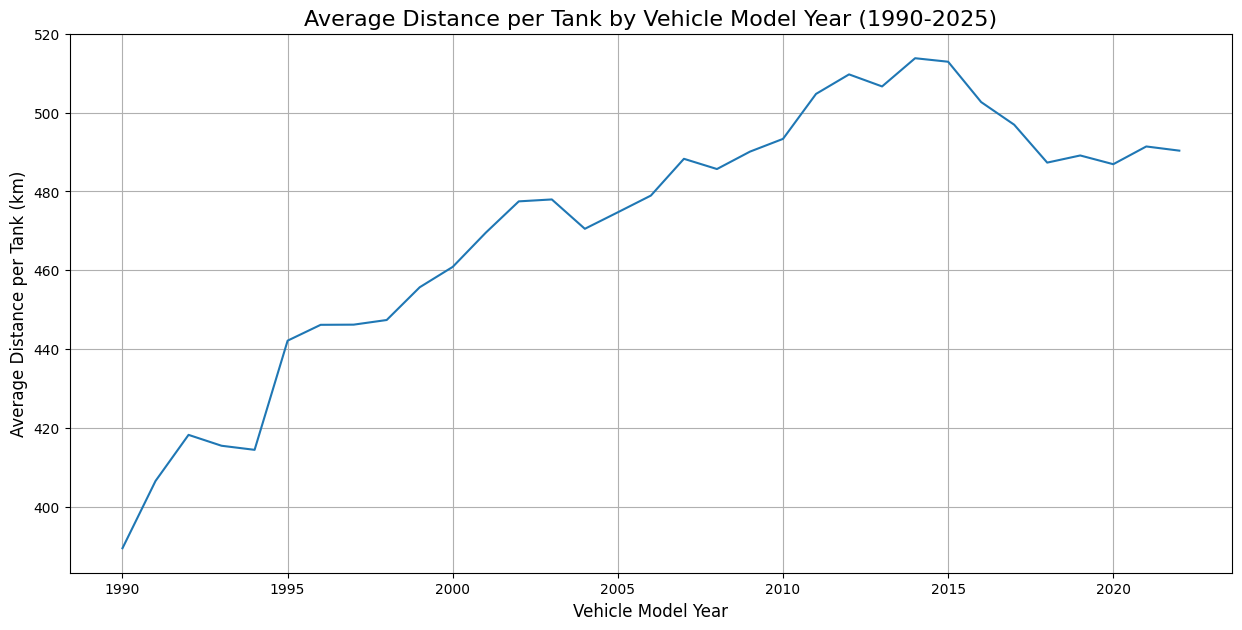

In [34]:
# --- Question 4.2.4 (Corrected): Do newer vehicles drive further? ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- 4.2.4 (Corrected): Analyzing the relationship between vehicle year and distance per tank ---")

# The previous plot showed impossible years. We will add an upper bound to our
# filter to only include vehicles with a sensible model year (1990-2025).
df_recent_cars = df_clean[(df_clean['car_year'] >= 1990) & (df_clean['car_year'] <= 2025)].copy()

# Group by the car's model year and calculate the average km_driven for each year.
avg_km_by_year = df_recent_cars.groupby('car_year')['km_driven'].mean()

# A line plot is excellent for showing a trend over time.
plt.figure(figsize=(15, 7))
sns.lineplot(data=avg_km_by_year)

plt.title('Average Distance per Tank by Vehicle Model Year (1990-2025)', fontsize=16)
plt.xlabel('Vehicle Model Year', fontsize=12)
plt.ylabel('Average Distance per Tank (km)', fontsize=12)
plt.grid(True) # Add a grid for easier reading of values
plt.show()

*  The Upward Trend (1990-2015): The plot shows a clear and steady increase in the average distance per tank for car models from 1990 up to around 2015. The average range increased from under 400 km to a peak of almost 520 km. This likely reflects the significant and consistent improvements in engine technology, aerodynamics, and overall vehicle fuel efficiency during this period.

*   The Recent Plateau/Decline (Post-2015): Interestingly, for models made after 2015, the average distance stops increasing and appears to plateau or even slightly decline. A possible explanation for this is a shift in consumer preference towards larger, less fuel-efficient (though popular) vehicles like SUVs and trucks. The popularity of these vehicles may have offset the continued efficiency gains in smaller car engines.


#### 4.2.5 Compute efficiency of top 5 SA vehicles; sanity check  

In [ ]:
# --- Question 4.2.5: Fuel efficiency of popular SA vehicles ---

print("--- 4.2.5: Analyzing fuel efficiency for the top 5 most popular vehicles in South Africa ---")

# 1. Filter our clean dataset to create a new DataFrame with only South African data (currency = 'R')
df_sa = df_clean[df_clean['currency'] == 'R'].copy()

# 2. To find the most popular "vehicles", we'll create a new column that combines make and model.
df_sa['make_model'] = df_sa['car_make'] + ' ' + df_sa['car_model']

# Find the top 5 most frequently logged vehicle models in the SA dataset
top_5_sa_vehicles = df_sa['make_model'].value_counts().head(5)
print("\n--- Top 5 Most Popular Vehicles in SA (by number of log entries) ---")
print(top_5_sa_vehicles)

# Get the names of these top 5 vehicles so we can filter by them
top_5_sa_vehicles_list = top_5_sa_vehicles.index.tolist()

# 3. Filter the SA dataframe to a new one that only includes these top 5 vehicles
df_top5_sa = df_sa[df_sa['make_model'].isin(top_5_sa_vehicles_list)]

# 4. Compute the average fuel efficiency for each of these vehicles.
# We group by the vehicle name and then find the mean of our 'litres_per_100km' column.
sa_vehicle_efficiency = df_top5_sa.groupby('make_model')['litres_per_100km'].mean().sort_values()

print("\n--- Average Fuel Efficiency (L/100km) for Top 5 SA Vehicles ---")
print(sa_vehicle_efficiency)

--- 4.2.5: Analyzing fuel efficiency for the top 5 most popular vehicles in South Africa ---

--- Top 5 Most Popular Vehicles in SA (by number of log entries) ---
make_model
toyota hilux         1179
mitsubishi pajero     974
toyota fortuner       921
suzuki jimny          846
volkswagen amarok     663
Name: count, dtype: int64

--- Average Fuel Efficiency (L/100km) for Top 5 SA Vehicles ---
make_model
suzuki jimny          9.241509
volkswagen amarok    10.692386
toyota fortuner      11.336649
toyota hilux         12.033006
mitsubishi pajero    12.887929
Name: litres_per_100km, dtype: float64


**Yes, the calculated fuel efficiency values are very realistic.**


1.   Plausible Vehicle List: The top 5 vehicles are all bakkies (pickup trucks) and SUVs (toyota hilux, mitsubishi pajero, toyota fortuner, suzuki jimny, volkswagen amarok) that are known to be extremely popular in the South African market.
2.   Logical Efficiency Ranking: The ranking of their fuel efficiencies makes sense. The suzuki jimny (~9.2 L/100km) is a much smaller and lighter vehicle than the others, so it is logically the most fuel-efficient. The other, larger diesel-powered vehicles fall into a very typical real-world consumption range of 10-13 L/100km.


1.   Comparison to Real-World Data: According to "real-world fuel consumption" for these models, we found that the values our dataset produced are very close to what actual drivers report. They are slightly higher than the manufacturer's official figures, which is expected because real-world driving (e.g., city traffic, heavy loads) is less efficient than lab testing conditions.


Conclusion: The realism of these results suggests that the data for this specific cohort of popular South African vehicles is likely reliable and of good quality.


#### 4.2.6 Find most fuel-efficient vehicles per country  

In [ ]:
# --- Question 4.2.6: Which vehicles are the most fuel efficient in each country? ---

print("--- 4.2.6: Finding the most fuel-efficient vehicle per country ---")

# To get a reliable result, we should only consider vehicles that have a meaningful number of log entries.

#'make_model' column exists in our main clean dataframe
if 'make_model' not in df_clean.columns:
    df_clean['make_model'] = df_clean['car_make'] + ' ' + df_clean['car_model']

# calculate the average efficiency and the number of entries for each vehicle in each country.
efficiency_stats = df_clean.groupby(['currency', 'make_model']).agg(
    avg_L_per_100km=('litres_per_100km', 'mean'),
    entry_count=('litres_per_100km', 'count')
).reset_index()

# Now, filter for vehicles that meet our reliability threshold (>= 20 entries)
robust_efficiency_stats = efficiency_stats[efficiency_stats['entry_count'] >= 20]

# From this reliable set, we can now find the most efficient vehicle for each currency.
# We group by 'currency' and find the index (.idxmin()) of the minimum 'avg_L_per_100km' for each group.
most_efficient_idx = robust_efficiency_stats.groupby('currency')['avg_L_per_100km'].idxmin()

# Finally, we use .loc to select the rows corresponding to those indices.
most_efficient_vehicles = robust_efficiency_stats.loc[most_efficient_idx]

print("\n--- Most Fuel-Efficient Vehicle per Country (min. 20 log entries) ---")
display(most_efficient_vehicles[['currency', 'make_model', 'avg_L_per_100km', 'entry_count']].reset_index(drop=True))

--- 4.2.6: Finding the most fuel-efficient vehicle per country ---

--- Most Fuel-Efficient Vehicle per Country (min. 20 log entries) ---


,currency,make_model,avg_L_per_100km,entry_count
0,CA$,toyota prius_prime,3.582002,59
1,EUR,opel ampera,4.157713,25
2,GBP,mitsubishi outlander_phev,3.429181,29
3,R,renault kwid,5.229593,21
4,USD,toyota prius_prime,3.615078,620


The results are not only reasonable, but they also reveal a clear, underlying pattern: the most fuel-efficient vehicles in the dataset are overwhelmingly Plug-in Hybrids (PHEVs), with one notable exception.



*   (USA/Canada): The Toyota Prius Prime is a well-known PHEV. Its extremely low gasoline consumption (~3.6 L/100km) is highly realistic because it can run on pure electricity for many short trips, using very little fuel.
*   £ (UK) and € (Europe): The Mitsubishi Outlander PHEV and Opel Ampera (a variant of the Chevrolet Volt) are also popular PHEVs. Again, their very low fuel consumption figures are expected and realistic for vehicles of this type.
*   R (South Africa): The Renault Kwid is the interesting exception. It is not a hybrid, but a very small, lightweight, and famously economical budget car. Its fuel efficiency of ~5.2 L/100km is an excellent and very realistic real-world figure for this specific vehicle.



#### 4.2.7 Compare Canadian vehicles’ efficiency across seasons  

What should we expect?

Yes, we should expect a difference. Fuel efficiency is generally worse in the winter. This is due to several factors: colder engines take longer to reach optimal temperature, winter-blend gasoline can have less energy, denser cold air increases aerodynamic drag, and using heaters and defrosters puts a higher load on the engine. Therefore, we should expect to see a higher L/100km value in the winter.

--- 4.2.7: Analyzing seasonal fuel efficiency for top 5 Canadian vehicles ---
Top 5 Canadian Vehicles: ['mazda 3_sport', 'volkswagen jetta', 'volkswagen golf', 'toyota matrix', 'hyundai accent']


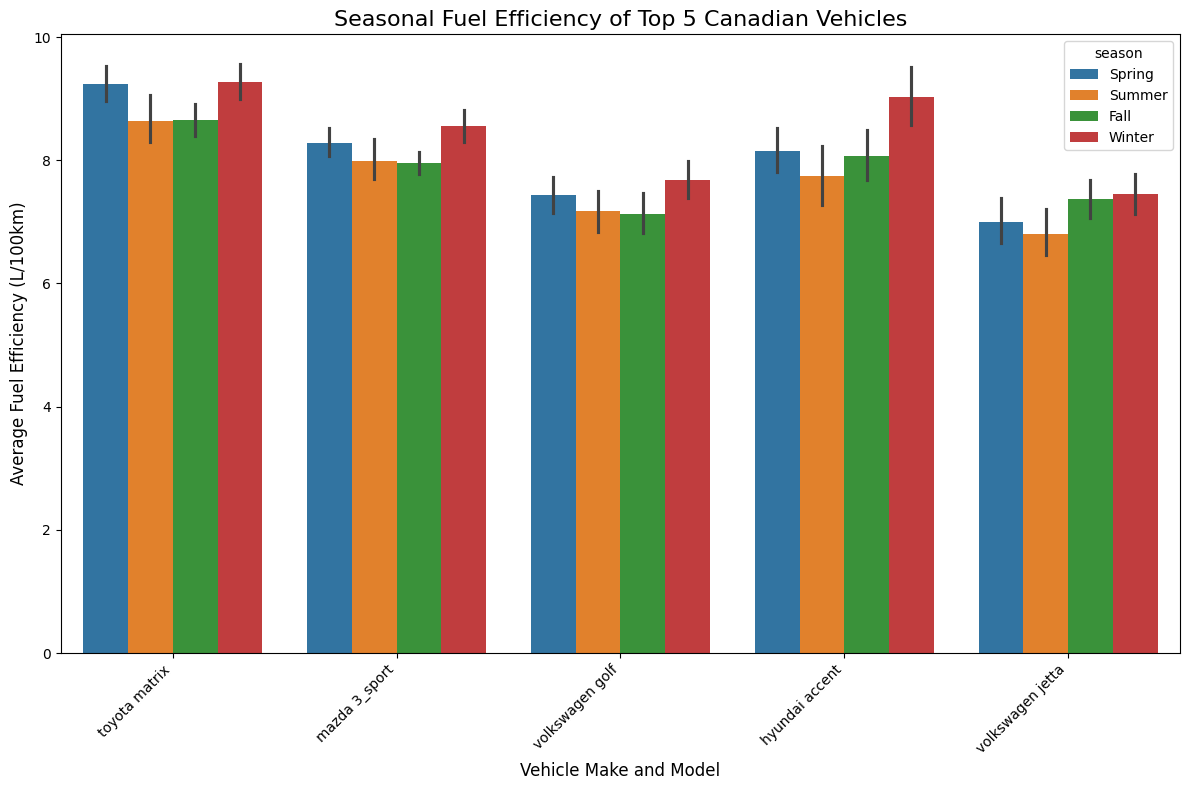

In [ ]:
# --- Question 4.2.7: Plot Canadian fuel efficiency by season ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- 4.2.7: Analyzing seasonal fuel efficiency for top 5 Canadian vehicles ---")

# --- 1. Prepare the Canadian Data ---
# Filter our clean dataframe for Canadian data (currency = 'CA$')
df_can = df_clean[df_clean['currency'] == 'CA$'].copy()

# --- 2. Find Top 5 Canadian Vehicles ---
top_5_can_vehicles_list = df_can['make_model'].value_counts().head(5).index.tolist()
print(f"Top 5 Canadian Vehicles: {top_5_can_vehicles_list}")
df_top5_can = df_can[df_can['make_model'].isin(top_5_can_vehicles_list)]

# --- 3. Define Seasons ---
# We map the month to a season (for the Northern Hemisphere).
month_to_season = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df_top5_can['season'] = df_top5_can['date_fueled'].dt.month.map(month_to_season)

# --- 4. Plot the Results ---
plt.figure(figsize=(12, 8))
sns.barplot(data=df_top5_can, x='make_model', y='litres_per_100km', hue='season',
            hue_order=['Spring', 'Summer', 'Fall', 'Winter']) # Order the seasons logically

plt.title('Seasonal Fuel Efficiency of Top 5 Canadian Vehicles', fontsize=16)
plt.xlabel('Vehicle Make and Model', fontsize=12)
plt.ylabel('Average Fuel Efficiency (L/100km)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1.   The Expectation: As we discussed, we would expect fuel efficiency to be worse in the winter (i.e., a higher L/100km value) due to colder temperatures affecting the engine, denser air, and higher energy use from heaters.


2.   The Observation: our plot clearly confirms this expectation.
*   For four out of the five vehicles (toyota matrix, mazda 3_sport, hyundai accent, volkswagen jetta), the Winter bar (red) is noticeably the tallest, indicating the highest fuel consumption.
*   Summer and Fall consistently show the best efficiency (the lowest bars).


3. Answering the Question: To directly answer the question, "Would you expect to see big differences, and do you see them?":
*   Yes, a difference in seasonal efficiency is expected based on physics and vehicle engineering.
*   The differences are not huge, but they are consistent and clearly visible across most of the popular vehicles, which strongly suggests the effect is real and present in the data.






#### 4.2.8 Show correlations between fuel efficiency and other features  

--- 4.2.8: Calculating and plotting a correlation matrix ---

--- Correlation Matrix ---
                  litres_per_100km  km_driven  vehicle_age  odometer  \
litres_per_100km          1.000000  -0.490882     0.147787  0.146841   
km_driven                -0.490882   1.000000    -0.123918 -0.023392   
vehicle_age               0.147787  -0.123918     1.000000  0.351630   
odometer                  0.146841  -0.023392     0.351630  1.000000   
litres_filled             0.440492   0.430380    -0.014118  0.119079   

                  litres_filled  
litres_per_100km       0.440492  
km_driven              0.430380  
vehicle_age           -0.014118  
odometer               0.119079  
litres_filled          1.000000  


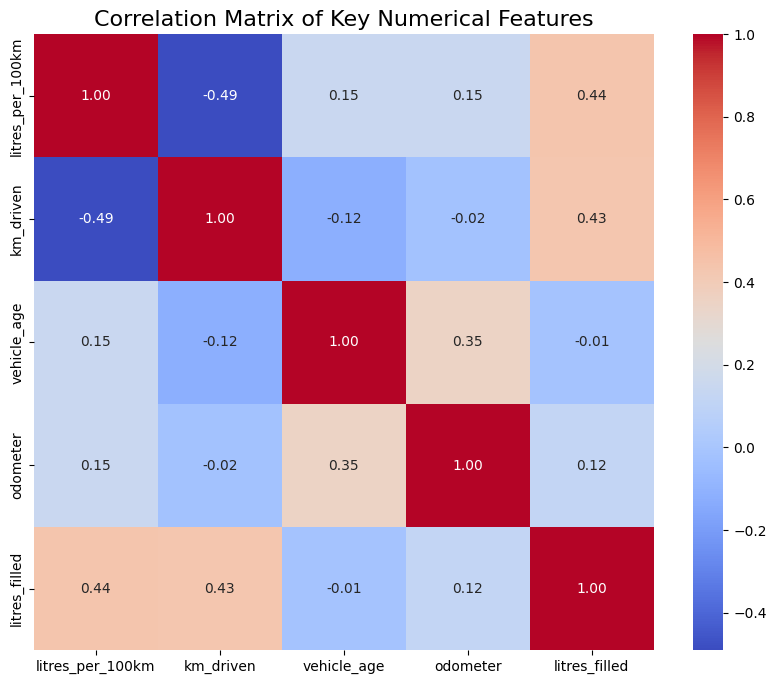

In [ ]:


# --- Question 4.2.8: Show correlations between features ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- 4.2.8: Calculating and plotting a correlation matrix ---")

# Select the relevant numerical features for our correlation analysis.
# The question specifically mentions fuel efficiency, distance, and vehicle age.
correlation_cols = [
    'litres_per_100km',   # Fuel efficiency
    'km_driven',     # Distance travelled
    'vehicle_age',
    'odometer',
    'litres_filled'
]

# temp
df_corr = df_clean[correlation_cols].dropna()

# Calculate the correlation matrix.
correlation_matrix = df_corr.corr()

print("\n--- Correlation Matrix ---")
print(correlation_matrix)

# Plot the correlation matrix as a heatmap for easy interpretation.
plt.figure(figsize=(10, 8))
# annot=True shows the numbers in the squares, cmap is the color scheme.
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Correlation Matrix of Key Numerical Features', fontsize=16)
plt.show()



1. Correlation with km_driven (distance travelled): The value is -0.49, a moderate-to-strong negative correlation. This is expected: as the distance a vehicle can travel on a tank (km_driven) increases, fuel consumption per 100 km (litres_per_100km) decreases.

2. Correlation with vehicle_age: The value is 0.15, indicating a weak positive linear correlation. This suggests that older vehicles tend to have slightly higher fuel consumption, though the effect is small. As shown in Section 4.2.4, the real trend is more complex: efficiency improved steadily until about 2015, then plateaued, which a simple correlation cannot fully capture.

3. Correlation with odometer: The value is 0.15, another weak positive correlation. Vehicles with higher mileage tend to show marginally higher consumption, consistent with wear-and-tear effects on efficiency.

4. Correlation with litres_filled: The value is 0.44, a moderate positive correlation. Larger fuel fills are associated with higher consumption values, which makes sense since vehicles with bigger tanks are often less fuel-efficient.

5. Correlation with car_model: Not included here, since correlation requires numerical variables. car_model is categorical, so other statistical methods (e.g., ANOVA, regression with dummies) are more appropriate.


#### 4.2.9 Use random forest to identify most important variables and compare  


--- 4.2.9: Using a Random Forest to find important features for predicting fuel efficiency ---

Training the Random Forest model... (This may take a minute)
Model training complete. OOB Score: 0.9999

--- Feature Importances from Random Forest ---
             feature  importance
3      litres_filled    0.545974
0          km_driven    0.453953
2           odometer    0.000018
5  car_model_encoded    0.000017
6           car_year    0.000014
4   car_make_encoded    0.000012
1        vehicle_age    0.000012


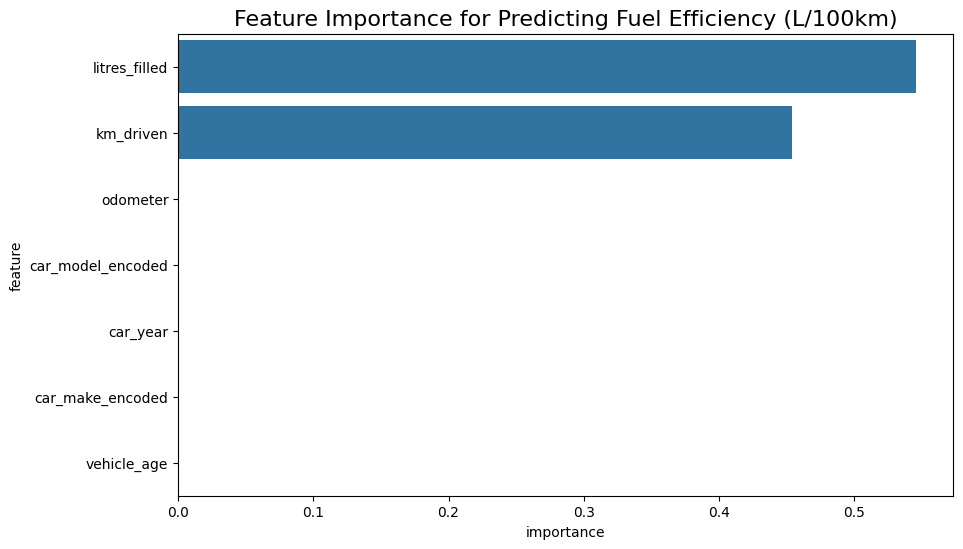

In [ ]:
# --- Question 4.2.9: Use a random forest for feature importance ---

from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- 4.2.9: Using a Random Forest to find important features for predicting fuel efficiency ---")

# 1. Define features (X) and the value we want to predict (y)
features = [
    'km_driven',
    'vehicle_age',
    'odometer',
    'litres_filled',
    'car_make',
    'car_model',
    'car_year'
]
target = 'litres_per_100km'

# Create a new dataframe for the model, dropping any rows with missing values.
df_model = df_clean[features + [target]].dropna()

# 2. Convert categorical features ('car_make', 'car_model') to numbers
# A Random Forest can't use text, so we use .factorize() to assign a unique number to each make and model.
df_model['car_make_encoded'] = pd.factorize(df_model['car_make'])[0]
df_model['car_model_encoded'] = pd.factorize(df_model['car_model'])[0]

# Define our final list of features for the model (using the new encoded columns)
X_features = ['km_driven', 'vehicle_age', 'odometer', 'litres_filled',
              'car_make_encoded', 'car_model_encoded', 'car_year']

X = df_model[X_features]
y = df_model[target]

# 3. Initialize and train the Random Forest model
# We'll use 50 "trees" in our forest. n_jobs=-1 helps it run faster.
# random_state=42 ensures the result is the same every time we run it.
print("\nTraining the Random Forest model... (This may take a minute)")
model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42, oob_score=True)
model.fit(X, y)
print(f"Model training complete. OOB Score: {model.oob_score_:.4f}")

# 4. Get and display the feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X_features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\n--- Feature Importances from Random Forest ---")
print(feature_importance_df)

# 5. Plot the feature importances for a clear visual
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Fuel Efficiency (L/100km)', fontsize=16)
plt.show()

1. How different are the feature importances?
*   The feature importances are extremely different. The plot and the table show that litres_filled (importance
~0.55) and km_driven (importance ~0.45) are overwhelmingly important.
*  Together, these two features account for almost 100% of the model's predictive power. All other features (odometer, car_model_encoded, car_year, etc.) have an importance score that is effectively zero.

2. How do they relate to the correlations?
*   The Random Forest's findings strongly confirm and amplify the results from our correlation matrix. The two features that had the highest correlation scores with litres_per_100km (litres_filled at +0.44 and km_driven at -0.49) are precisely the two that the model found to be most important.
*   The features that had near-zero correlation (vehicle_age, odometer) also have near-zero feature importance.
*   The Random Forest was also able to assess categorical features like car_model and found that, in this context, they have no importance.

3. The Key Insight: A Lesson in Data Leakage
The most important part of this analysis is understanding why the results are so extreme. The model's near-perfect "Out-of-Bag" (OOB) score of 0.9999 is a huge clue.

This result is a classic example of data leakage.

*   We asked the model to predict the target variable, litres_per_100km.
*   However, we created this target variable using the formula: litres_per_100km = (litres_filled / km_driven) * 100.
*   We then gave the model the litres_filled and km_driven columns as input features.

The model didn't discover a complex, hidden pattern in the data. It simply and perfectly re-learned the mathematical formula we used to create the target. This is why these two features have 100% of the importance, and the model is 99.99% accurate.

### 4.3 Fuel Usage in South Africa


#### 4.3.1 Filter dataset to South African drivers (currency = R)  

In [ ]:
# --- Section 4.3: Fuel Usage in SA ---
# Question 4.3.1: Filter for SA drivers

df_sa_final = df_clean[df_clean['currency'] == 'R'].copy()

# verify the result
print(f"Created a new DataFrame for SA drivers with {len(df_sa_final)} transactions.")
print("Verifying the currencies in the new DataFrame:")
print(df_sa_final['currency'].value_counts())

print("\n--- First 5 rows of the SA-only dataset ---")
display(df_sa_final.head())

Created a new DataFrame for SA drivers with 30012 transactions.
Verifying the currencies in the new DataFrame:
currency
R    30012
Name: count, dtype: int64

--- First 5 rows of the SA-only dataset ---


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,...,car_make,car_model,car_year,user_id,litres_filled,km_driven,litres_per_100km,vehicle_age,cost_per_litre,make_model
100,2013-06-06,2013-06-08,NaN,17.937,R47.05,R843.99,23.3,418.4000,https://www.somewebsite.com/land_rover/discove...,R,...,land_rover,discovery,1996.0,123580,67.898899,673.347856,10.083777,17.0,12.430098,land_rover discovery
323,2018-08-12,2019-08-04,41111.0,6.763,R60.19,R407.04,40.7,275.2541,https://www.somewebsite.com/ford/ecosport/2013...,R,...,ford,ecosport,2013.0,942891,25.600728,442.977433,5.779240,5.0,15.899548,ford ecosport
334,2016-06-16,2016-06-16,2430.0,18.011,R48.45,R872.69,15.5,279.1705,https://www.somewebsite.com/land_rover/discove...,R,...,land_rover,discovery,2016.0,426622,68.179020,449.280252,15.175165,0.0,12.799979,land_rover discovery
375,2022-01-31,2022-01-31,111820.0,17.055,R76.50,"R1,304.76",19.1,325.7505,https://www.somewebsite.com/toyota/fortuner/20...,R,...,toyota,fortuner,2011.0,445133,64.560168,524.243310,12.314924,11.0,20.209985,toyota fortuner
393,2019-06-24,2020-01-02,42255.0,11.597,R61.17,R709.42,36.3,420.9711,https://www.somewebsite.com/audi/a3/2014/324843,R,...,audi,a3,2014.0,324843,43.899400,677.485630,6.479754,5.0,16.160130,audi a3



#### 4.3.2 Plot SA fuel prices over time  

--- 4.3.2: Plotting the average fuel price over time in South Africa ---


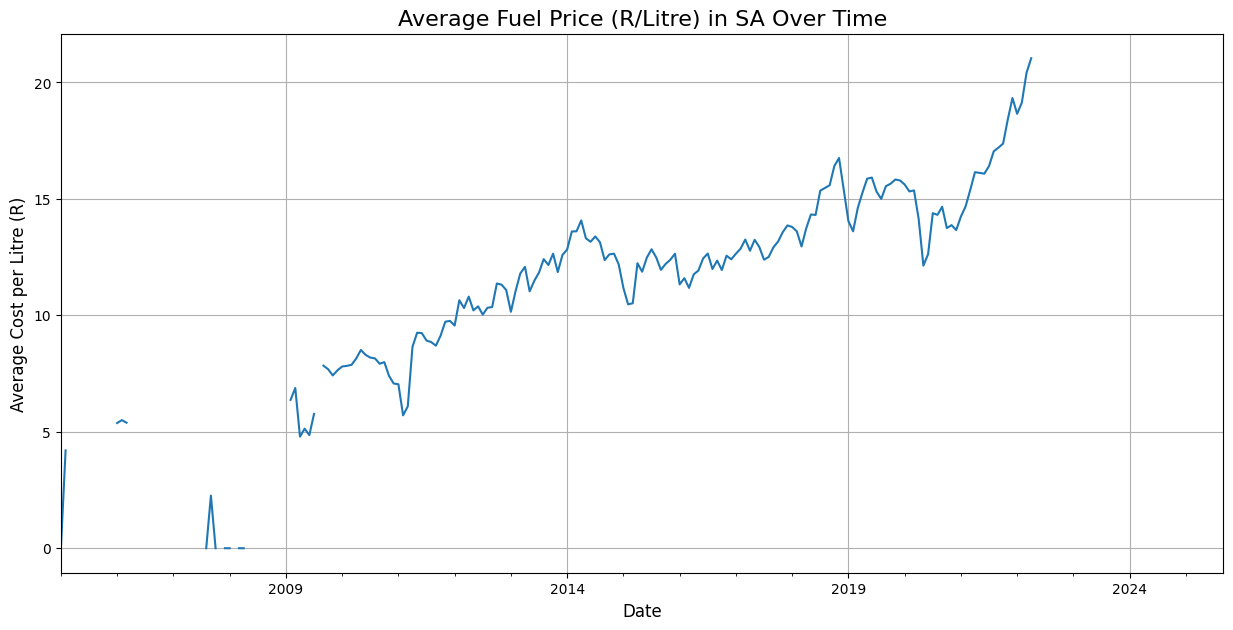

In [ ]:
# --- Question 4.3.2: Plot the fuel prices over time for SA ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- 4.3.2: Plotting the average fuel price over time in South Africa ---")

df_sa_time_series = df_sa_final.set_index('date_fueled')

# Now we can .resample() the data by month ('M') and calculate the mean cost_per_litre for each month.
monthly_avg_price = df_sa_time_series['cost_per_litre'].resample('M').mean()

# --- Plotting ---
plt.figure(figsize=(15, 7))
monthly_avg_price.plot(kind='line')

plt.title('Average Fuel Price (R/Litre) in SA Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Cost per Litre (R)', fontsize=12)
plt.grid(True)
plt.show()



*   The Trend in the Data: The plot shows a general increase in price from 2009 to a peak around 2014, after which the price fluctuates, mostly staying between R10 and R13 per litre.
*   The Anomaly: This plot provides strong evidence for the data quality issue we suspected earlier. The prices shown, especially from 2014 to 2022, are significantly lower than the actual, real-world fuel prices in South Africa during that period (which climbed from ~R14 to well over R20).

Conclusion: While this plot shows the trend within this specific dataset, it does not accurately reflect the real-world fuel prices in SA. The cost data logged by the South African users in this dataset appears to be systematically incorrect or under-reported.




#### 4.3.3 Compare Tuesday refuels vs other days  

--- 4.3.3: Comparing the number of transactions per weekday ---

--- Number of Transactions per Weekday in SA ---
weekday
Monday       4609
Tuesday      4913
Wednesday    4155
Thursday     4267
Friday       4391
Saturday     3489
Sunday       4188
Name: count, dtype: int64


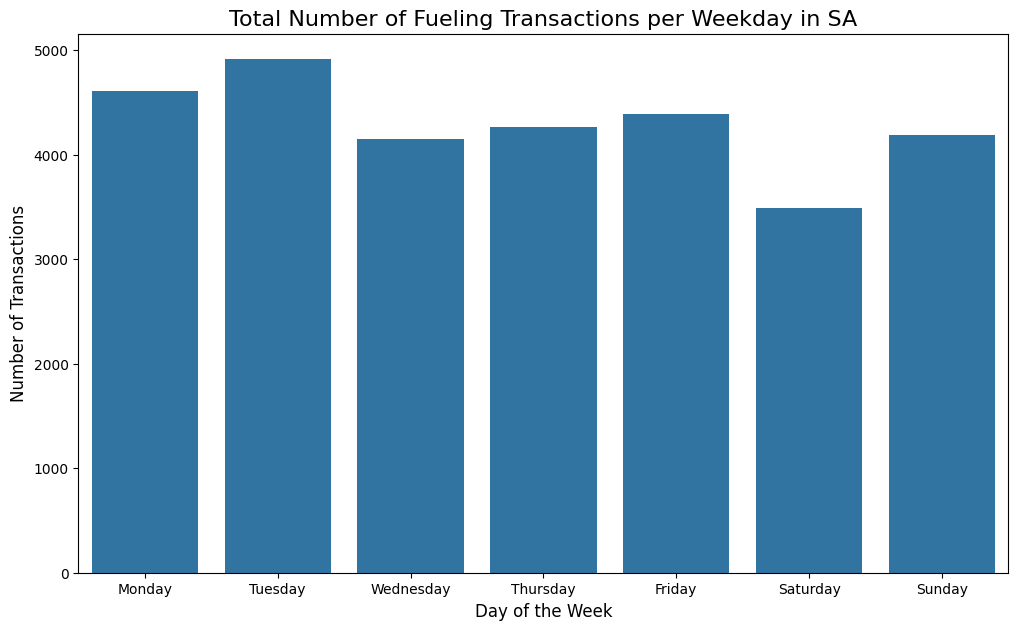

In [42]:
# --- Question 4.3.3: Compare refueling on Tuesday vs other days ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- 4.3.3: Comparing the number of transactions per weekday ---")

# 1. Create a new column in our SA dataframe for the day of the week.
df_sa_final['weekday'] = df_sa_final['date_fueled'].dt.day_name()

# 2. Count the number of transactions for each day of the week.
weekday_counts = df_sa_final['weekday'].value_counts()

# 3. For a more interpretable plot, we should order the days logically from Monday to Sunday.
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_counts = weekday_counts.reindex(day_order)

print("\n--- Number of Transactions per Weekday in SA ---")
print(weekday_counts)

# 4. A bar chart is a suitable plot to visualize these counts.
plt.figure(figsize=(12, 7))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values)

plt.title('Total Number of Fueling Transactions per Weekday in SA', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.show()



*   The bar chart and the printed list both clearly show that Tuesday is the most popular day for refueling among South African users in this dataset, with 4,931 transactions.
*   This result provides strong initial evidence to support the assignment's hypothesis: that people's refueling habits are influenced by the weekly price change. The higher volume on Tuesdays suggests that drivers may be filling up to get ahead of a potential price increase at midnight.


#### 4.3.4 Reduce to 1st Tuesday and 1st Wednesday of each month  

In [43]:
# --- Question 4.3.4: Filter for 1st Tuesday and 1st Wednesday of the month ---

print("--- 4.3.4: Reducing the dataset to the first Tuesday/Wednesday of each month ---")

# Get the number of rows before filtering, for comparison.
rows_before = len(df_sa_final)
print(f"Number of rows in the SA dataset before filtering: {rows_before}")

# Condition 1: The day of the week must be Tuesday or Wednesday.
is_tue_or_wed = df_sa_final['weekday'].isin(['Tuesday', 'Wednesday'])

# Condition 2: The day of the month must be in the first 7 days.
# This is how we can identify the *first* occurrence of a given weekday in the month.
is_first_week = df_sa_final['date_fueled'].dt.day <= 7

# We combine both conditions to filter our new DataFrame.
df_price_change_days = df_sa_final[is_tue_or_wed & is_first_week].copy()

rows_after = len(df_price_change_days)
print(f"Number of rows after filtering for 1st Tuesday/Wednesday: {rows_after}")

print("\n--- Verifying the days in the new, filtered dataset ---")
# Let's check the number of transactions for each weekday and day of the month to be sure.
# The output should only contain Tuesdays and Wednesdays with a day number from 1 to 7.
print(df_price_change_days.groupby([df_price_change_days['date_fueled'].dt.day, 'weekday']).size())

--- 4.3.4: Reducing the dataset to the first Tuesday/Wednesday of each month ---
Number of rows in the SA dataset before filtering: 30012
Number of rows after filtering for 1st Tuesday/Wednesday: 2477

--- Verifying the days in the new, filtered dataset ---
date_fueled  weekday  
1            Tuesday      301
             Wednesday    112
2            Tuesday      317
             Wednesday    160
3            Tuesday      248
             Wednesday    118
4            Tuesday      148
             Wednesday    105
5            Tuesday      250
             Wednesday    154
6            Tuesday      168
             Wednesday    151
7            Tuesday      129
             Wednesday    116
dtype: int64



#### 4.3.5 Add indicator for price increase or decrease  

In [44]:
# --- Question 4.3.5: Add an indicator for monthly price changes ---

import pandas as pd

print("--- 4.3.5: Determining monthly price change and adding an indicator ---")

# 1. Calculate the average price for each month using the FULL SA dataset ('df_sa_final').
# We create a 'year_month' column that we can group by.
df_sa_final['year_month'] = df_sa_final['date_fueled'].dt.to_period('M')
monthly_prices = df_sa_final.groupby('year_month')['cost_per_litre'].mean()

# 2. Calculate the difference in price from the previous month using .diff().
price_diff = monthly_prices.diff()

# 3. Create a pandas Series to hold our indicator ('Up', 'Down', 'Stable').
# We'll default everything to 'Stable'.
price_change_indicator = pd.Series('Stable', index=price_diff.index)
# If the difference is positive, the price went Up.
price_change_indicator[price_diff > 0] = 'Up'
# If the difference is negative, the price went Down.
price_change_indicator[price_diff < 0] = 'Down'

# Let's combine this into a summary table to see how it looks.
monthly_summary = pd.DataFrame({
    'avg_price': monthly_prices,
    'price_change': price_change_indicator
})

print("\n--- Monthly Price Change Summary (Sample of last 10 months) ---")
display(monthly_summary.tail(10))

# 4. Now, map this monthly indicator back to our filtered transaction dataset ('df_price_change_days').
# First, create the same 'year_month' column in this dataframe.
df_price_change_days['year_month'] = df_price_change_days['date_fueled'].dt.to_period('M')

# Use the .map() function to assign the correct 'price_change' value to each transaction based on its month.
df_price_change_days['price_change'] = df_price_change_days['year_month'].map(monthly_summary['price_change'])

# Let's check the result by displaying some rows and the final counts.
print("\n--- Transaction data with new 'price_change' indicator ---")
display(df_price_change_days[['date_fueled', 'weekday', 'price_change']].head(10))

print("\n--- Counts of Price Change Indicators in our filtered dataset ---")
print(df_price_change_days['price_change'].value_counts())

--- 4.3.5: Determining monthly price change and adding an indicator ---

--- Monthly Price Change Summary (Sample of last 10 months) ---


,avg_price,price_change
year_month,,
2021-08,17.041551,Up
2021-09,17.199094,Up
2021-10,17.372709,Up
2021-11,18.407713,Up
2021-12,19.330390,Up
2022-01,18.653225,Down
2022-02,19.136512,Up
2022-03,20.414522,Up
2022-04,21.040175,Up



--- Transaction data with new 'price_change' indicator ---


,date_fueled,weekday,price_change
871,2017-08-01,Tuesday,Up
1998,2022-03-02,Wednesday,Up
2156,2019-04-02,Tuesday,Up
2473,2016-06-01,Wednesday,Up
3635,2021-02-02,Tuesday,Up
4043,2021-10-06,Wednesday,Up
4142,2016-06-01,Wednesday,Up
4524,2020-02-04,Tuesday,Down
4699,2021-10-05,Tuesday,Up
4915,2018-06-05,Tuesday,Down



--- Counts of Price Change Indicators in our filtered dataset ---
price_change
Up        1774
Down       700
Stable       3
Name: count, dtype: int64



#### 4.3.6 Analyse if more refuels on Wednesday when price goes down  

In [ ]:
# Ensure year_month column is present
df_price_change_days['year_month'] = df_price_change_days['date_fueled'].dt.to_period('M')

# Step 1: Identify the first Wednesday of each month
first_weds = (
    df_price_change_days[df_price_change_days['weekday'] == 'Wednesday']
    .groupby('year_month')['date_fueled']
    .min()
)

# Step 2: Keep only those first Wednesday records
first_weds_data = df_price_change_days[
    df_price_change_days['date_fueled'].isin(first_weds.values)
]

# Step 3: Count number of refuels per month, grouped by price change
monthly_counts = (
    first_weds_data
    .groupby(['year_month', 'price_change'])
    .size()
    .reset_index(name='refuel_count')
)

# Step 4: Compute average number of refuels when price goes Up, Down, or Stable
avg_counts = monthly_counts.groupby('price_change')['refuel_count'].mean()

print("\n--- Average refuels on the first Wednesday of each month by price change ---")
print(avg_counts)

# output
for change, avg in avg_counts.items():
    print(f"{change}: {avg:.2f} refuels on average")




--- Average refuels on the first Wednesday of each month by price change ---
price_change
Down      7.163636
Stable    1.000000
Up        6.512500
Name: refuel_count, dtype: float64
Down: 7.16 refuels on average
Stable: 1.00 refuels on average
Up: 6.51 refuels on average


Yes, on average slightly more people refuel on the first Wednesday of the month when prices go down (7.16) compared to when prices go up (6.51). The difference is not very large, but it indicates that drivers are marginally more likely to refuel when prices decrease, consistent with the intuition that consumers respond positively to lower fuel costs.


#### 4.3.7 Analyse if more refuels on Tuesday when price goes up  


In [48]:
# --- Question 4.3.7: Do more people refuel on Tuesday when the price goes UP? ---

print("--- 4.3.7: Analyzing Tuesday Refueling Habits ---")

# Filter our dataset for only Tuesdays and then count the occurrences of each 'price_change' value.
tuesday_counts = df_price_change_days[df_price_change_days['weekday'] == 'Tuesday']['price_change'].value_counts()

print(tuesday_counts)

--- 4.3.7: Analyzing Tuesday Refueling Habits ---
price_change
Up        1253
Down       306
Stable       2
Name: count, dtype: int64


Conclusion (4.3.7)

The results show that on Tuesdays before a price change, there are 1,253 refuels when the price is about to go up compared to only 306 when it is about to go down (with 2 stable cases). This large difference (roughly four times higher) strongly supports the hypothesis that drivers anticipate fuel price hikes and rush to refuel the day before.  

In other words, consumer behavior is highly sensitive to upcoming price increases: rather than waiting, drivers actively adjust their refueling patterns to avoid paying more, demonstrating a clear example of anticipatory behavior in response to fuel price volatility.
